# Sentiment analysis 

# Introduction
Analyze & classify sentiment of text data, articles into positive or negative

# Objective
Sentiment analysis notebooks dives in very depth of various concepts, methods related to text analysis and understand the meaning of it semantically and/or syntactly. They are classified in the following five based notebooks based on different methods & tools used to analyze & classify text.

1. Sentiment Analysis with Text Blob, Word Cloud, Count Vectorizer, N-Gram
2. Sentiment Analysis using Doc2Vec, N-Gram & Phrase Modelling
3. Sentiment Analysis with Chi2 Square & PCA Dimension Reduction
4. Sentiment Analysis with Keras & Tensorflow
5. Sentiment Analysis with Keras & Tensorflow using Doc2Vec, Pretrained GloVe

# UNO
## 1. Sentiment Analysis with Text Blob, Word Cloud, Count Vectorizer, N-Gram, Zif2 law, Lexical Analysis

## Data Scraping

https://github.com/dataquestio/twitter-scrape frameworks to scrape & store data into db, dump into csv file
https://github.com/ideoforms/python-twitter-examples
https://github.com/zachwhalen/ssbot twitter bot using spreadsheet

In [87]:
# Basic import

import re
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
import imageio
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [41]:
# Load data

cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("./trainingandtestdata/training.1600000.processed.noemoticon.csv",header=None, names=cols, encoding='latin-1')



In [3]:
# Data visualiztion

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment       1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
user            1600000 non-null object
text            1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


sentiment          id                          date query_string  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009     NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009     NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009     NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [4]:
# Sentiment counts
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [5]:
# Drop columns
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [6]:
# Map positive sentiment to 1, negative to 0
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

## Data Preparation

In [7]:
# Add length of tweets before cleaning it
df['pre_clean_len'] = [len(t) for t in df.text]

In [8]:
# Data dictionary

data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}

data_dict

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
  'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
  'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}

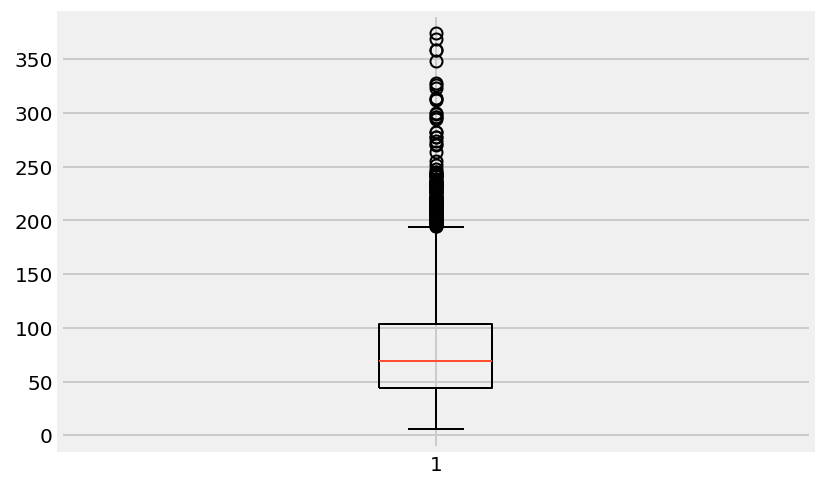

In [9]:
# Boxplot of tweets length

fig, ax = plt.subplots()
plt.boxplot(df.pre_clean_len)
plt.show()

In [10]:
# Check for tweets exceeding twitter's character limit of 140 characters

df[df.pre_clean_len > 140].head(10)

sentiment                                               text  \
213           0  Awwh babs... you look so sad underneith that s...   
226           0  Tuesdayï¿½ll start with reflection ï¿½n then a...   
279           0  Whinging. My client&amp;boss don't understand ...   
343           0  @TheLeagueSF Not Fun &amp; Furious? The new ma...   
400           0  #3 woke up and was having an accident - &quot;...   
464           0  My bathtub drain is fired: it haz 1 job 2 do, ...   
492           0  pears &amp; Brie, bottle of Cabernet, and &quo...   
747           0  Have an invite for &quot;Healthy Dining&quot; ...   
957           0  Damnit I was really digging this season of Rea...   
1064          0  Why do I keep looking...I know that what I rea...   

      pre_clean_len  
213             142  
226             141  
279             145  
343             145  
400             144  
464             146  
492             150  
747             141  
957             141  
1064            141

### Steps to clean tweets text

###### I) HTML Decoding : '&amp','&quot' 
###### II) Mentions : @
###### III) URL links : http://twitpic.com/2y1zl
###### IV) UTF-8 BOM (Byte Order Mark) : \xef\xbf\xb
###### V) Hashtags : #love

In [11]:
# From NLTK library

tok = WordPunctTokenizer()

In [12]:
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

### New Steps to clean tweets text

###### Souping
###### BOM removing
###### url address('http:'pattern), twitter ID removing
###### url address('www.'pattern) removing
###### lower-case
###### negation handling
###### removing numbers and special characters
###### tokenizing and joining

In [13]:
# Twitter cleaner updated

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [16]:
%%time
# Cleaning tweets and saving as a dataframe

df['text'] = df['text'].apply(lambda tweet: tweet_cleaner_updated(tweet))
df.to_hdf('./data/redstone.hdf', 'Redstone')

CPU times: user 7min 43s, sys: 4.75 s, total: 7min 48s
Wall time: 7min 48s


In [ ]:
df

In [17]:
# Checking for null entries column, row wise

np.sum(df.isnull().any(axis=1))
np.sum(df.isnull().any(axis=0))

0

In [19]:
# Drop missing values

df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
sentiment        1600000 non-null int64
text             1600000 non-null object
pre_clean_len    1600000 non-null int64
dtypes: int64(2), object(1)
memory usage: 36.6+ MB


## Word Cloud

In [27]:
# Postive & Negative sentiments

positive_df = df[df['sentiment'] == 1]
positive = pd.Series(positive_df.text.tolist()).str.cat(sep=' ')

negative_df = df[df['sentiment'] == 0]
negative = pd.Series(negative_df.text.tolist()).str.cat(sep=' ')

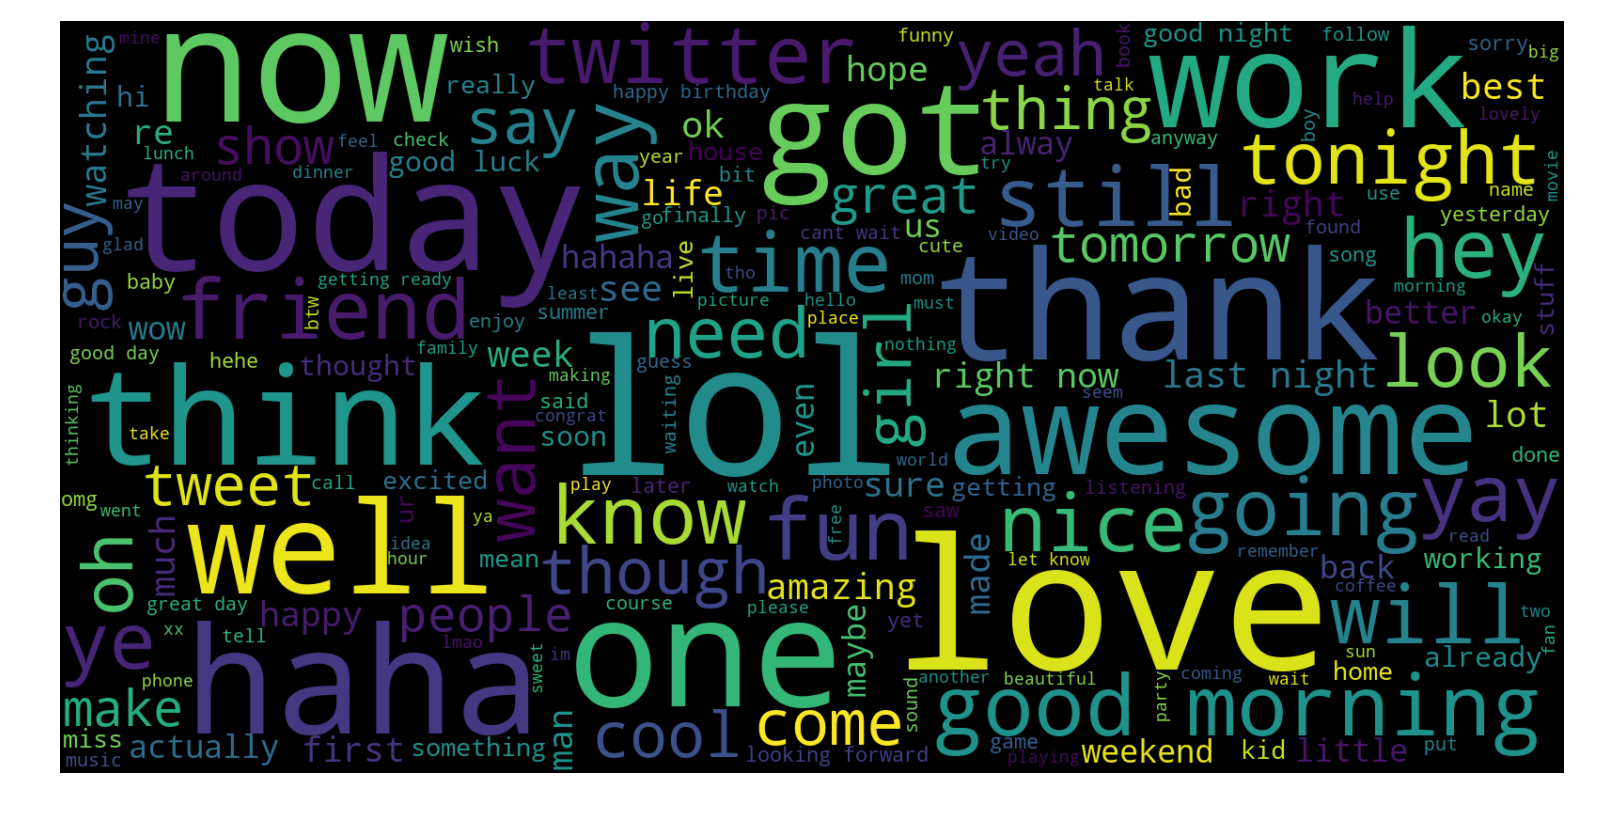

In [25]:
# Wordcloud beautification

from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=200).generate(positive)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

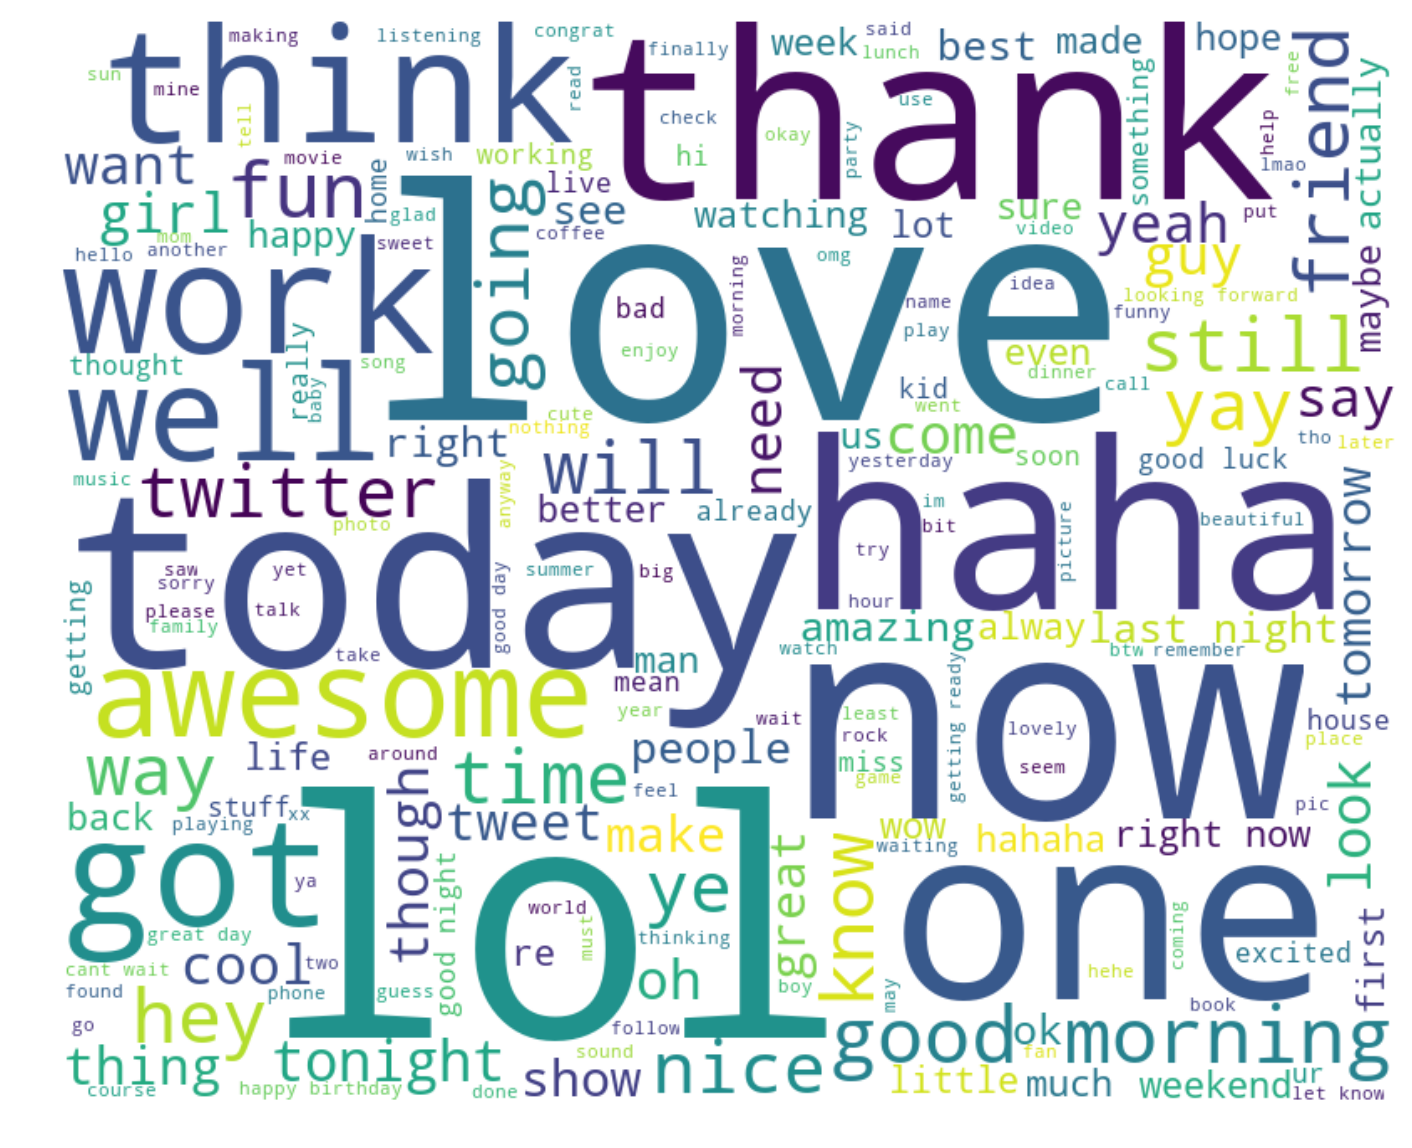

In [46]:
# Using Twitter birdy to display positive sentiments

bird = imageio.imread('/home/indiano/PycharmProjects/TwitterAI/redstone/data/nightingle.png')
wordcloud = WordCloud(background_color="white", stopwords=STOPWORDS, mask=bird).generate(positive)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

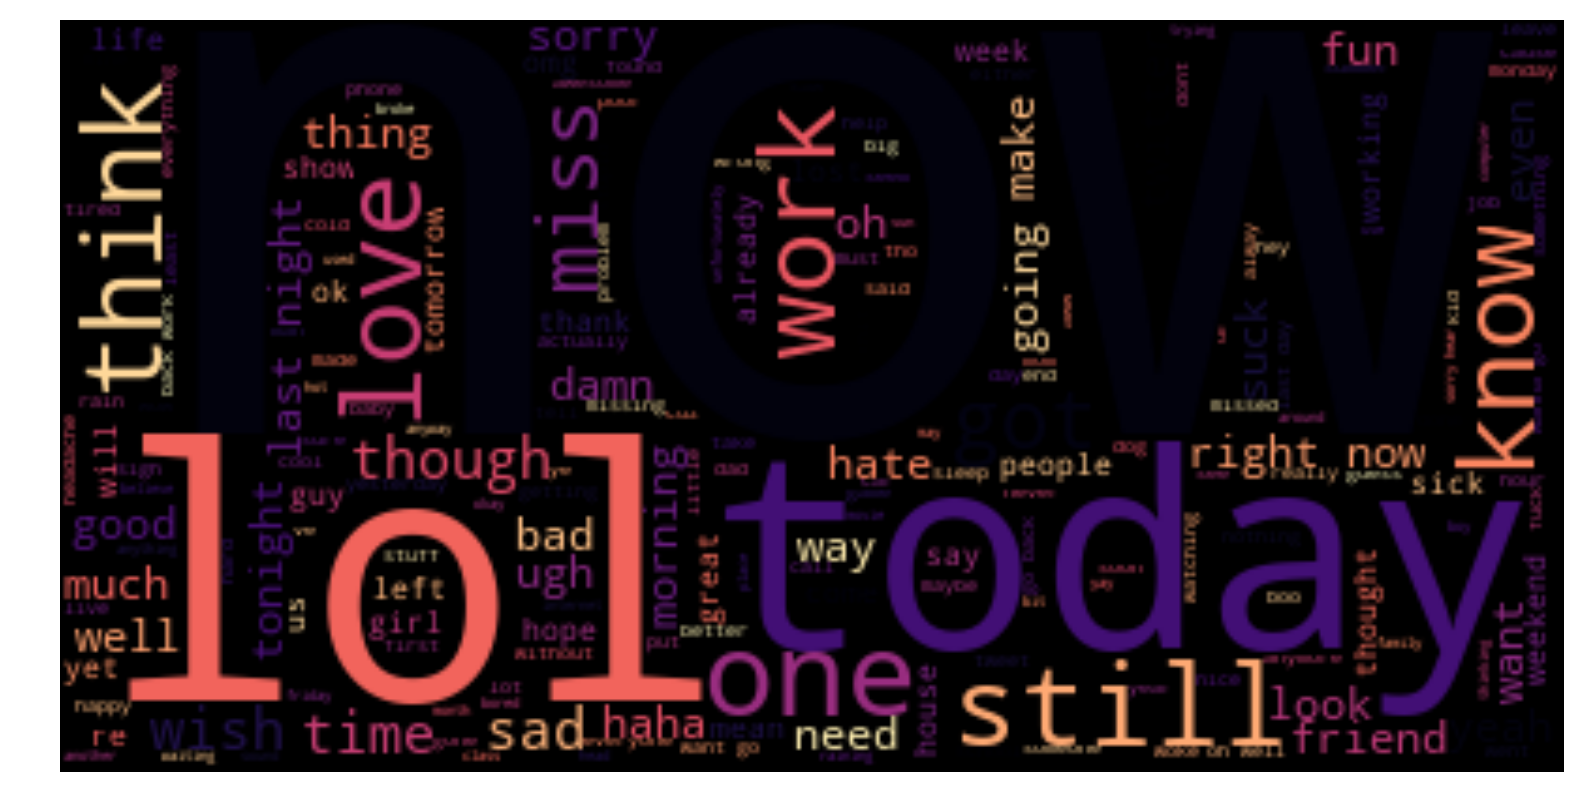

In [47]:
# Wordcloud horrorification

from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=200, colormap='magma').generate(negative)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [60]:
# Delete unwanted lists
del positive, negative, wordcloud

### TF-IDF Analysis (Term Frequency - Inverse Document Frequency)

In [3]:
# Count vectorizer

from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(df.text)

NameError: name 'df' is not defined

In [59]:
cvec_features = cvec.get_feature_names()
len(cvec_features)

684358

In [69]:
# Calculating positive, negative matrices and summing along rows

negtive_matrix = cvec.transform(negative_df.text)
positive_matrix = cvec.transform(positive_df.text)

# Summing tf-idf values 
neg_tf = np.sum(negtive_matrix, axis=0)
pos_tf = np.sum(positive_matrix, axis=0)

# Remove single-dimensional entries from the shape of an array.
negative = np.squeeze(np.asarray(neg_tf))
positive = np.squeeze(np.asarray(pos_tf))

# tf-idf values saved in the dataframe
tf_df = pd.DataFrame([negative, positive], columns=cvec.get_feature_names()).transpose()
tf_df.to_hdf('./data/tfidf.hdf', 'TFIDF')

In [70]:
positive_df.info()
positive_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 800000 to 1599999
Data columns (total 3 columns):
sentiment        800000 non-null int64
text             800000 non-null object
pre_clean_len    800000 non-null int64
dtypes: int64(2), object(1)
memory usage: 24.4+ MB


sentiment                                               text  \
800000          1                                 love guys the best   
800001          1  im meeting up with one of my besties tonight c...   
800002          1  thanks for the twitter add sunisa got to meet ...   
800003          1  being sick can be really cheap when it hurts t...   
800004          1                     he has that effect on everyone   

        pre_clean_len  
800000             44  
800001             72  
800002            137  
800003            104  
800004             47

In [41]:
# Read TF dataframe

tf_df = pd.read_hdf('./data/tfidf.hdf')
tf_df.info()
tf_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 684358 entries, 00 to ù¾ø
Data columns (total 2 columns):
0    684358 non-null int64
1    684358 non-null int64
dtypes: int64(2)
memory usage: 15.7+ MB


0  1
00            0  0
000           0  0
0000          0  0
00000         0  0
000000000000  0  0

In [42]:
# Sorting positive, negative sentiments

tf_df.columns = ['negative', 'positive']
tf_df['total'] = tf_df['negative'] + tf_df['positive']

tf_df.to_csv('./data/tfidf.csv', encoding='utf-8')
tf_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
to     313162    252567  565729
the    257836    265998  523834
my     190775    125955  316730
it     157448    147786  305234
and    153958    149642  303600
you    103844    198245  302089
not    194724     86861  281585
is     133432    111191  244623
in     115542    101160  216702
for     98999    117369  216368

In [43]:
# Read saved csv file

tf_df = pd.read_csv('./data/tfidf.csv', index_col=0, encoding='utf_8')
tf_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
to     313162    252567  565729
the    257836    265998  523834
my     190775    125955  316730
it     157448    147786  305234
and    153958    149642  303600
you    103844    198245  302089
not    194724     86861  281585
is     133432    111191  244623
in     115542    101160  216702
for     98999    117369  216368

### Tweets Tokens Visualisation

In [4]:
# Read TF dataframe

df = pd.read_hdf('./data/redstone.hdf')

# Data visualiztion

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
sentiment        1600000 non-null int64
text             1600000 non-null object
pre_clean_len    1600000 non-null int64
dtypes: int64(2), object(1)
memory usage: 48.8+ MB


sentiment                                               text  pre_clean_len
0          0  awww that bummer you shoulda got david carr of...            115
1          0  is upset that he can not update his facebook b...            111
2          0  dived many times for the ball managed to save ...             89
3          0     my whole body feels itchy and like its on fire             47
4          0  no it not behaving at all mad why am here beca...            111

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english', max_features=10000)
cvec.fit(df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [6]:
# Document Matrix 

document_matrix = cvec.transform(df.text)
display(document_matrix[0:5])

<5x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [13]:
# Calculating Term Frequency for Postive + Sentiment entries

%%time

pos_batches = np.linspace(798179, 1596019, 10).astype(int)
batch_len = len(pos_batches)-1

pos_tf = []
for idx in range(batch_len):
    print(pos_batches[idx])
    p_batch_res = np.sum(document_matrix[pos_batches[idx]:pos_batches[idx+1]].toarray(), axis=0)
    
    pos_tf.append(p_batch_res)
    
    # Runtime update
    print('Term Frequency calculated for {} Postive + Sentiment entry'.format(pos_batches[idx+1]))


798179
Term Frequency calculated for 886827 Postive + Sentiment entry
886827
Term Frequency calculated for 975476 Postive + Sentiment entry
975476
Term Frequency calculated for 1064125 Postive + Sentiment entry
1064125
Term Frequency calculated for 1152774 Postive + Sentiment entry
1152774
Term Frequency calculated for 1241423 Postive + Sentiment entry
1241423
Term Frequency calculated for 1330072 Postive + Sentiment entry
1330072
Term Frequency calculated for 1418721 Postive + Sentiment entry
1418721
Term Frequency calculated for 1507370 Postive + Sentiment entry
1507370
Term Frequency calculated for 1596019 Postive + Sentiment entry
CPU times: user 5.93 s, sys: 8.47 s, total: 14.4 s
Wall time: 14.4 s


In [14]:
# Calculating Term Frequency for Negative - Sentiment entries

%%time

neg_batches = np.linspace(0, 798179, 10).astype(int)
batch_len = len(neg_batches)-1

neg_tf = []
for idx in range(batch_len):
    print(neg_batches[idx])
    n_batch_res = np.sum(document_matrix[neg_batches[idx]:neg_batches[idx+1]].toarray(), axis=0)

    neg_tf.append(n_batch_res)
    
    # Runtime update
    print('Term Frequency calculated for {} Negative - Sentiment entry'.format(neg_batches[idx+1]))

0
Term Frequency calculated for 88686 Negative - Sentiment entry
88686
Term Frequency calculated for 177373 Negative - Sentiment entry
177373
Term Frequency calculated for 266059 Negative - Sentiment entry
266059
Term Frequency calculated for 354746 Negative - Sentiment entry
354746
Term Frequency calculated for 443432 Negative - Sentiment entry
443432
Term Frequency calculated for 532119 Negative - Sentiment entry
532119
Term Frequency calculated for 620805 Negative - Sentiment entry
620805
Term Frequency calculated for 709492 Negative - Sentiment entry
709492
Term Frequency calculated for 798179 Negative - Sentiment entry
CPU times: user 6.09 s, sys: 8.94 s, total: 15 s
Wall time: 15 s


In [15]:
display(pos_tf)
display(neg_tf)

[array([13,  7,  6, ...,  7,  7,  7]),
 array([9, 4, 1, ..., 5, 4, 6]),
 array([ 8,  8,  5, ..., 10,  7,  4]),
 array([12, 11,  3, ...,  9,  6,  4]),
 array([9, 6, 1, ..., 6, 3, 6]),
 array([15,  9,  2, ...,  4,  5,  6]),
 array([ 7,  2,  3, ..., 10,  5,  2]),
 array([14,  5,  4, ...,  6,  4,  3]),
 array([5, 3, 4, ..., 8, 6, 6])]

[array([15,  7,  2, ...,  7,  8,  5]),
 array([15,  9,  8, ..., 11,  0,  3]),
 array([26,  8,  3, ...,  8,  3,  2]),
 array([12, 11,  3, ...,  5,  4,  2]),
 array([21, 17,  6, ...,  4,  5,  5]),
 array([15, 11,  3, ...,  6,  3,  3]),
 array([17,  7,  6, ...,  6,  8,  3]),
 array([18,  8, 10, ...,  2,  8,  4]),
 array([21, 14,  4, ...,  4,  5,  3])]

In [12]:
# Need to debug

# %%time

# pos_batches = np.linspace(798179, 1596019, 10).astype(int)
# neg_batches = np.linspace(0, 798179, 10).astype(int)
# if (len(pos_batches)-1 == len(neg_batches)-1):
#     batch_len = len(pos_batches)-1

# pos_tf = neg_tf = []
# for idx in range(batch_len):
#     print(pos_batches[idx])
#     print(neg_batches[idx])
#     p_batch_res = np.sum(document_matrix[pos_batches[idx]:pos_batches[idx+1]].toarray(), axis=0)
#     n_batch_res = np.sum(document_matrix[neg_batches[idx]:neg_batches[idx+1]].toarray(), axis=0)

#     pos_tf.append(p_batch_res)
#     neg_tf.append(n_batch_res)
    
#     # Runtime update
#     print('Term Frequency calculated for {} Postive + Sentiment entry'.format(pos_batches[idx+1]))
#     print('Term Frequency calculated for {} Negative - Sentiment entry'.format(neg_batches[idx+1]))

798179
0
Term Frequency calculated for 886827 Postive + Sentiment entry
Term Frequency calculated for 88686 Negative - Sentiment entry
886827
88686
Term Frequency calculated for 975476 Postive + Sentiment entry
Term Frequency calculated for 177373 Negative - Sentiment entry
975476
177373
Term Frequency calculated for 1064125 Postive + Sentiment entry
Term Frequency calculated for 266059 Negative - Sentiment entry
1064125
266059
Term Frequency calculated for 1152774 Postive + Sentiment entry
Term Frequency calculated for 354746 Negative - Sentiment entry
1152774
354746
Term Frequency calculated for 1241423 Postive + Sentiment entry
Term Frequency calculated for 443432 Negative - Sentiment entry
1241423
443432
Term Frequency calculated for 1330072 Postive + Sentiment entry
Term Frequency calculated for 532119 Negative - Sentiment entry
1330072
532119
Term Frequency calculated for 1418721 Postive + Sentiment entry
Term Frequency calculated for 620805 Negative - Sentiment entry
1418721
620

In [16]:
neg = np.sum(neg_tf, axis=0)
pos = np.sum(pos_tf, axis=0)

tf_df = pd.DataFrame([neg, pos], columns=cvec.get_feature_names()).transpose()
tf_df.columns = ['negative', 'positive']
tf_df['total'] = tf_df['negative'] + tf_df['positive']

tf_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
just      63820     62807  126627
good      29142     61856   90998
day       41305     47988   89293
like      40994     37421   78415
today     38016     29989   68005
work      45337     19489   64826
going     33642     30856   64498
love      16967     47481   64448
got       33354     27963   61317
lol       23096     35998   59094

In [63]:
tf_df.sort_values(by='positive', ascending=False)['positive'][:50]

just        62807
good        61856
day         47988
love        47481
like        37421
lol         35998
thanks      34179
going       30856
time        30351
today       29989
got         27963
new         26813
know        25681
great       25198
ll          24514
night       23683
haha        21583
morning     20717
happy       20448
im          19928
work        19489
think       19475
twitter     19410
hope        19108
really      18464
fun         18455
did         17837
oh          17373
nice        16891
home        15882
thank       15670
tomorrow    14842
awesome     14404
watching    14339
wait        14018
hey         13999
need        13643
right       12775
yes         12760
yeah        12682
make        12628
way         12607
tonight     12568
better      12433
want        12416
come        12139
ve          12017
best        11228
getting     10798
gonna       10636
Name: positive, dtype: int64

<Figure size 1728x720 with 0 Axes>

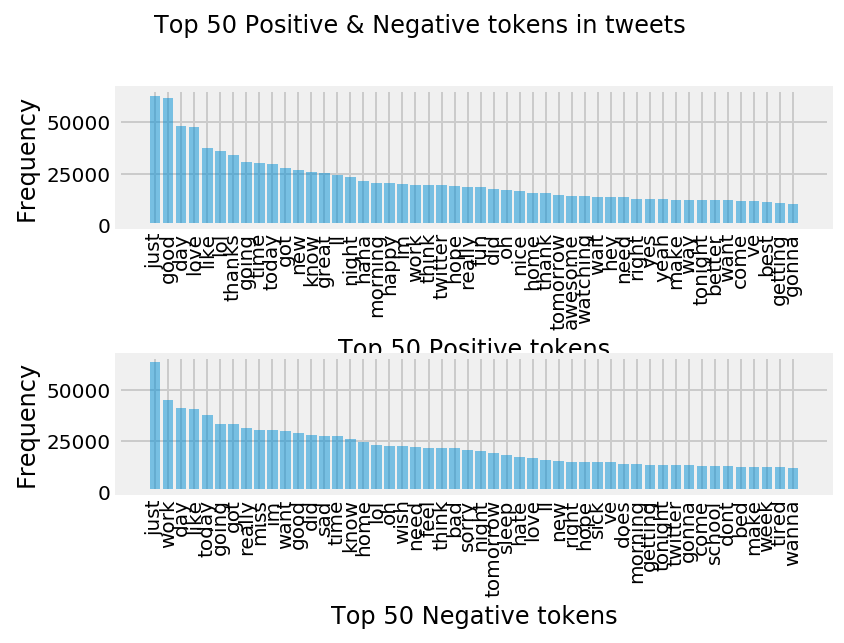

In [65]:
# Top 50 words

fifty_words = np.arange(50)

plt.figure(figsize=(24,10))

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Top 50 Positive & Negative tokens in tweets')

ax1.bar(fifty_words, tf_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
ax1.set_xlabel('Top 50 Positive tokens')
ax1.set_ylabel('Frequency')
ax1.set_xticks(fifty_words)
ax1.set_xticklabels(tf_df.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='vertical')

ax2.bar(fifty_words, tf_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
ax2.set_xlabel('Top 50 Negative tokens')
ax2.set_ylabel('Frequency')
ax2.set_xticks(fifty_words)
ax2.set_xticklabels(tf_df.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='vertical')

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15, left=0.15, wspace=0.15, hspace=.95)
#plt.colorbar(im2, cax=ax2)
plt.show()

Text(0.5,1,'Top 50 tokens in Positive tweets')

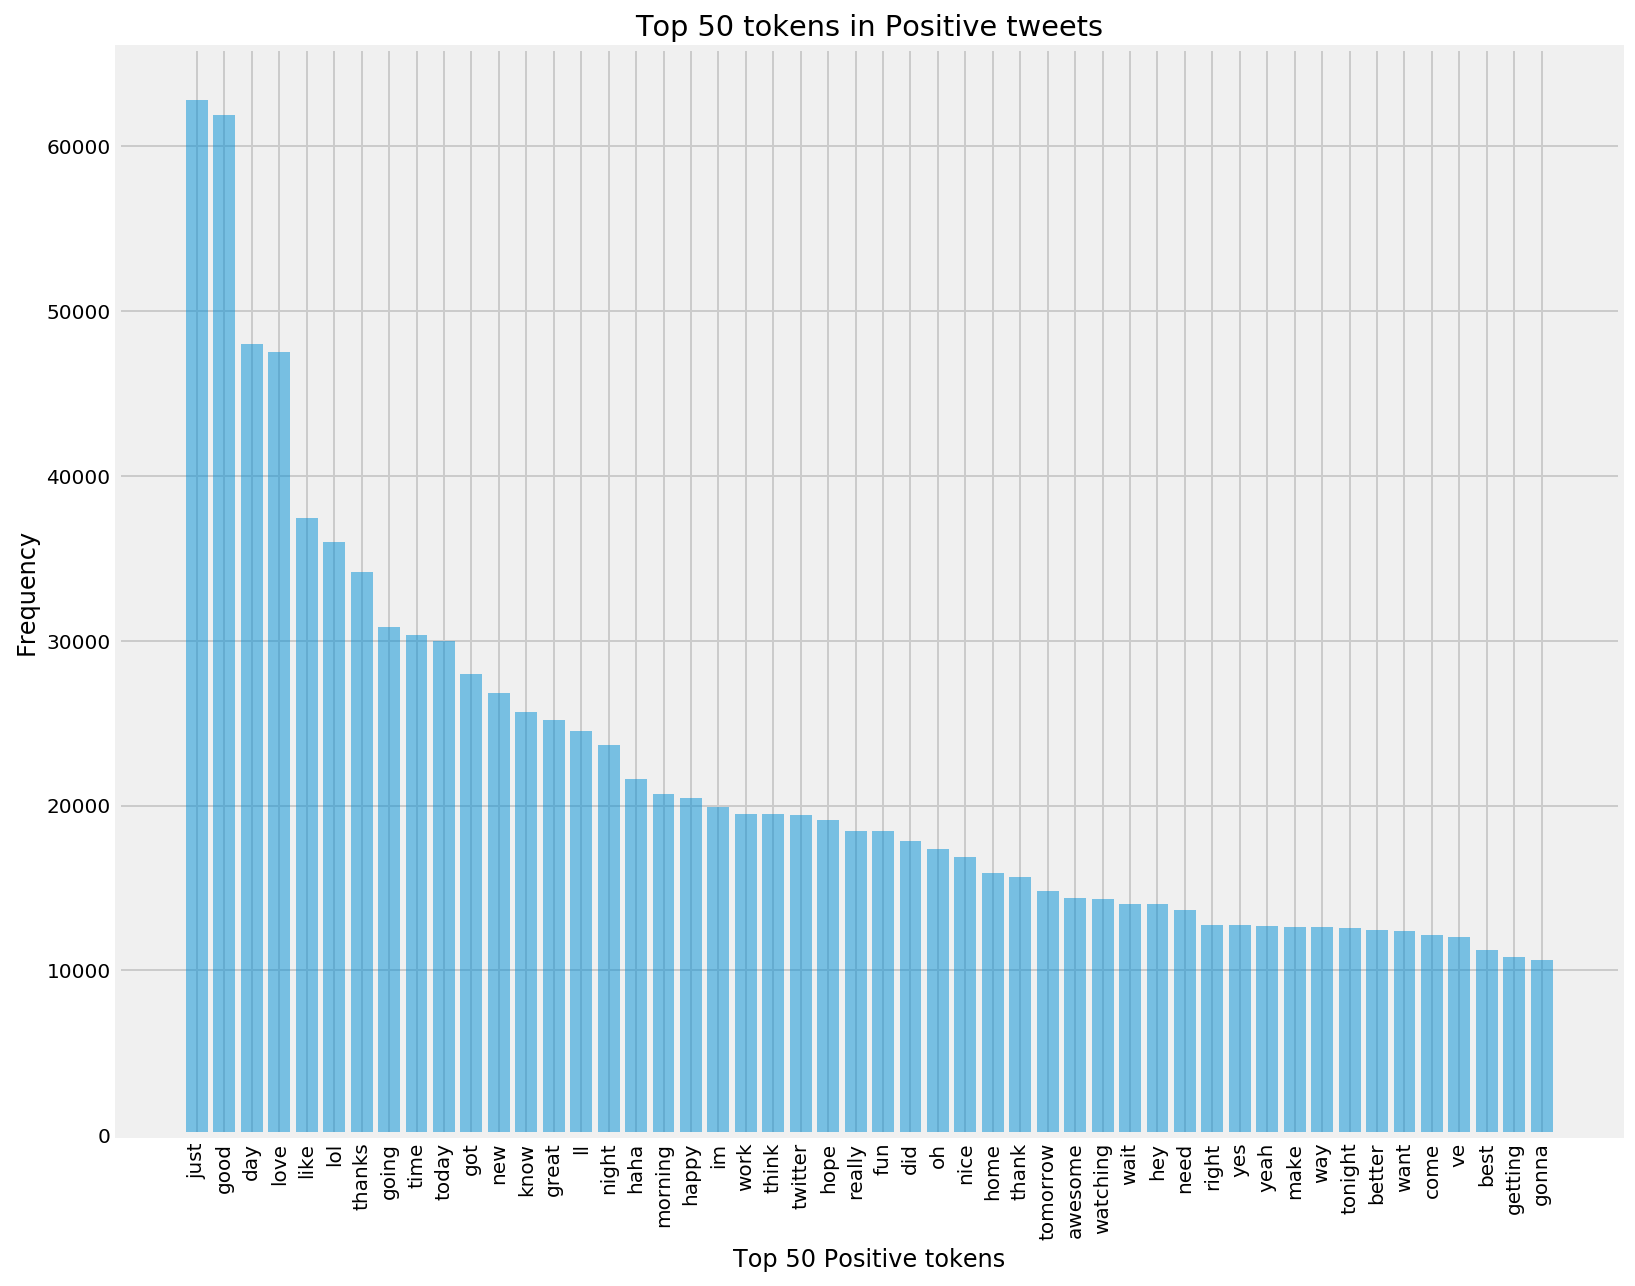

In [67]:
# Top 50 Positive words

fifty_words = np.arange(50)

plt.figure(figsize=(12,10))
plt.bar(fifty_words, tf_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)

plt.xlabel('Top 50 Positive tokens')
plt.ylabel('Frequency')
plt.xticks(fifty_words, tf_df.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='vertical')

plt.title('Top 50 tokens in Positive tweets')

Text(0.5,1,'Top 50 tokens in negative tweets')

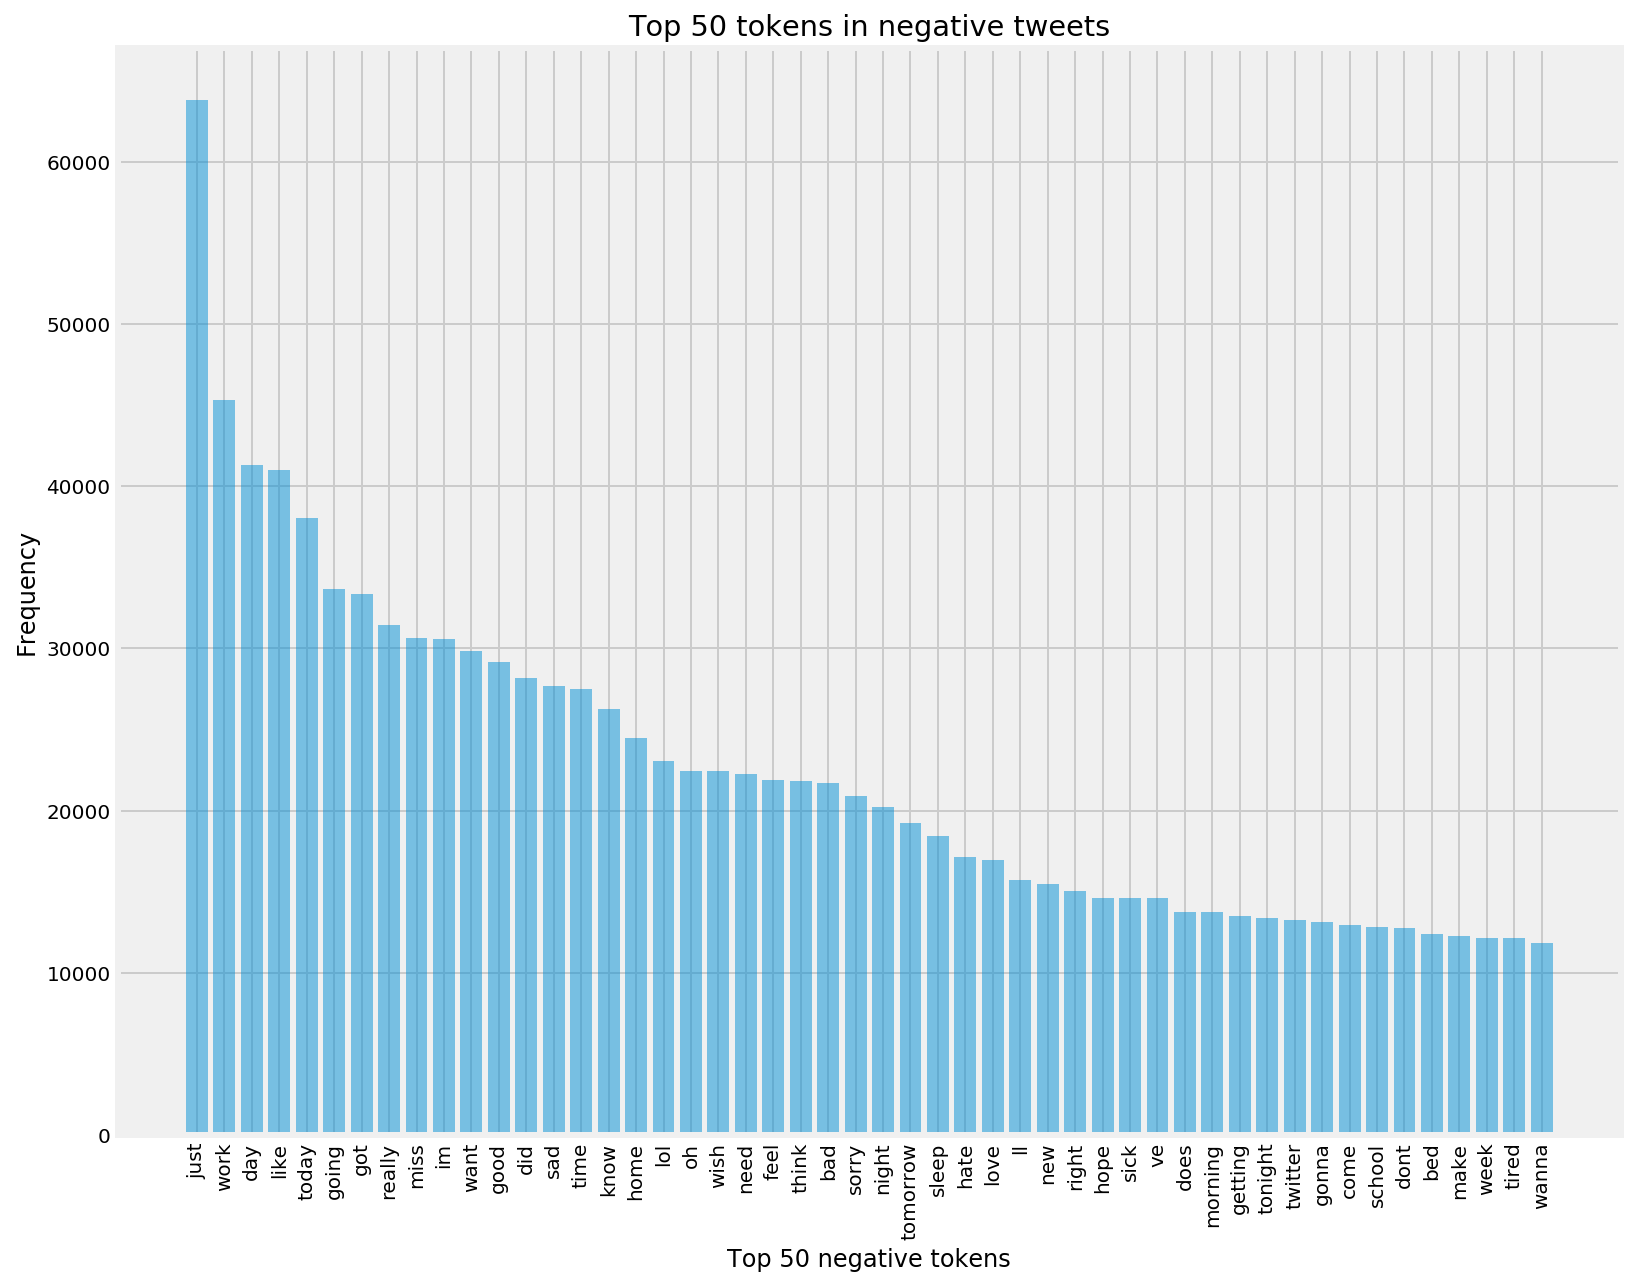

In [66]:
# Top 50 Negative words

fifty_words = np.arange(50)

plt.figure(figsize=(12,10))
plt.bar(fifty_words, tf_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)

plt.xlabel('Top 50 negative tokens')
plt.ylabel('Frequency')
plt.xticks(fifty_words, tf_df.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='vertical')

plt.title('Top 50 tokens in negative tweets')

Text(0.5,1,'Negative Frequency vs Positive Frequency')

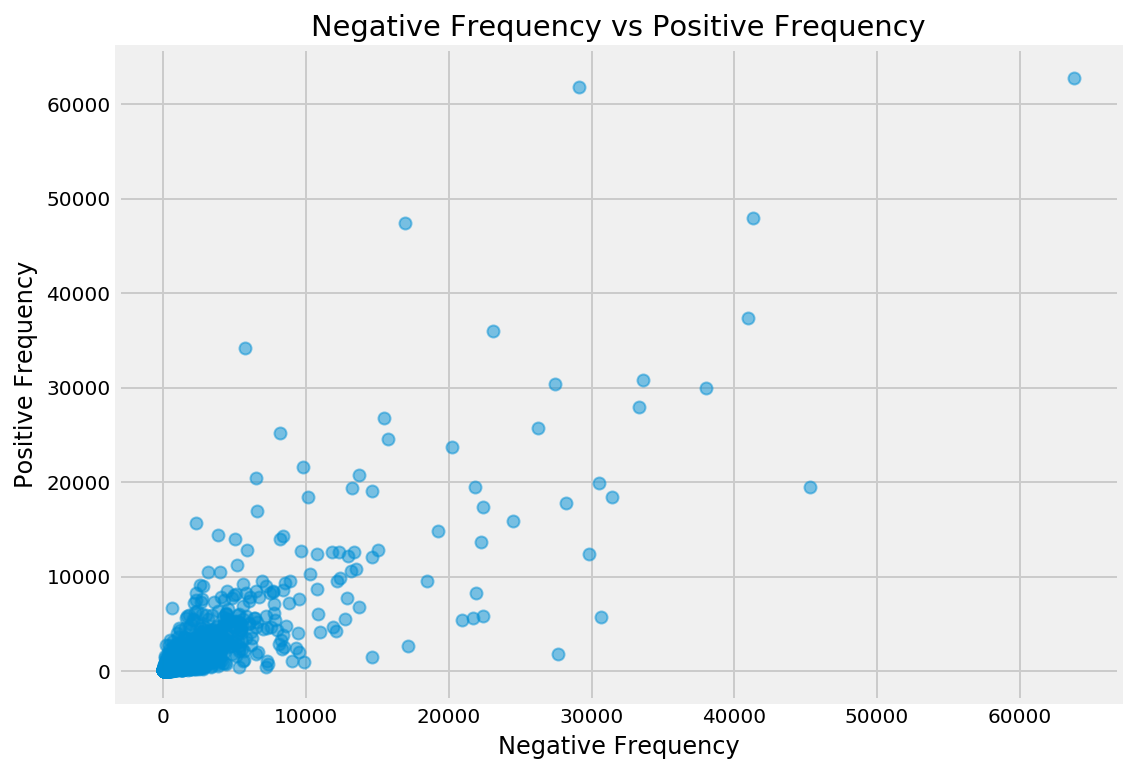

In [68]:
# Plot negative & positive frequency of a word on X-axis, Y-axis respectively

import seaborn as sns

plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive", fit_reg=False, scatter_kws={'alpha':0.5}, data=tf_df)

plt.xlabel('Negative Frequency')
plt.ylabel('Positive Frequency')

plt.title('Negative Frequency vs Positive Frequency')

#### Most of the words are below 10,000 on both X-axis & Y-axis and we cann't see a meaningful relation between negative and positive frequency.

#### The metrics from Scattertext is a good way to visualise text data and filter out meaningful tokens from the frequency data.

#### Intuitively, if a word appears more often in one class compared to another, this can be a good measure of how much the word is meaningful to characterise that class.

In [71]:
# Metrics from Scattertext

tf_df['pos_rate'] = tf_df['positive'] * 1./tf_df['total']

# Another metric is the frequency a words occurs in the class

tf_df['pos_freq_perc'] = tf_df['positive'] * 1./tf_df['positive'].sum()
tf_df.sort_values(by='pos_freq_perc', ascending=False).iloc[:10]

negative  positive   total  pos_rate  pos_freq_perc
just       63820     62807  126627  0.496000       0.014402
good       29142     61856   90998  0.679751       0.014184
day        41305     47988   89293  0.537422       0.011004
love       16967     47481   64448  0.736733       0.010888
like       40994     37421   78415  0.477217       0.008581
lol        23096     35998   59094  0.609165       0.008255
thanks      5754     34179   39933  0.855909       0.007838
going      33642     30856   64498  0.478402       0.007076
time       27475     30351   57826  0.524868       0.006960
today      38016     29989   68005  0.440982       0.006877

But since pos_freq_pct is just the frequency scaled over the total sum of the frequency, the rank of pos_freq_pct is exactly same as just the positive frequency.

What we can do now is to combine pos_rate, pos_freq_pct together to come up with a metric which reflects both pos_rate and pos_freq_pct. Even though both of these can take a value ranging from 0 to 1, pos_rate has much wider range actually spanning from 0 to 1, while all the pos_freq_pct values are squashed within the range smaller than 0.015. If we average these two numbers, pos_rate will be too dominant, and will not reflect both metrics effectively.

So here we use harmonic mean instead of arithmetic mean. "Since the harmonic mean of a list of numbers tends strongly toward the least elements of the list, it tends (compared to the arithmetic mean) to mitigate the impact of large outliers and aggravate the impact of small ones." 

In [72]:
from scipy.stats import hmean

# Calculating harmonic mean of pos_rate & pos_freq_perc

tf_df['pos_hmean'] = tf_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_perc']]) 
                                 if x['pos_rate'] > 0 and x['pos_freq_perc'] > 0 
                                 else 0), axis=1)                                                        
tf_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

negative  positive   total  pos_rate  pos_freq_perc  pos_hmean
just       63820     62807  126627  0.496000       0.014402   0.027992
good       29142     61856   90998  0.679751       0.014184   0.027788
day        41305     47988   89293  0.537422       0.011004   0.021567
love       16967     47481   64448  0.736733       0.010888   0.021459
like       40994     37421   78415  0.477217       0.008581   0.016859
lol        23096     35998   59094  0.609165       0.008255   0.016289
thanks      5754     34179   39933  0.855909       0.007838   0.015533
going      33642     30856   64498  0.478402       0.007076   0.013945
time       27475     30351   57826  0.524868       0.006960   0.013737
today      38016     29989   68005  0.440982       0.006877   0.013542

The harmonic mean rank seems like the same as pos_freq_pct. By calculating the harmonic mean, the impact of small value (in this case, pos_freq_pct) is too aggravated and ended up dominating the mean value. This is again exactly same as just the frequency value rank and doesn't provide a meaningful result.

What we can try next is to get the CDF (Cumulative Distribution Function) value of both pos_rate and pos_freq_pct. CDF can be explained as "distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x". By calculating CDF value, we can see where the value of either pos_rate or pos_freq_pct lies in the distribution in terms of cumulative manner. In the below result of the code, we can see a word "welcome" with pos_rate_normcdf of 0.995625, and pos_freq_pct_normcdf of 0.999354. This means roughly 99.56% of the tokens will take a pos_rate value less than or equal to 0.91535, and 99.99% will take a pos_freq_pct value less than or equal to 0.001521.

Next, we calculate a harmonic mean of these two CDF values, as we did earlier. By calculating the harmonic mean, we can see that pos_normcdf_hmean metric provides a more meaningful measure of how important a word is within the class.

In [75]:
# Calculate Cumulative Distribution Function value of both pos_rate and pos_freq_perc.

from scipy.stats import norm

def norm_cdf(x):
    return norm.cdf(x, x.mean(), x.std())

tf_df['pos_rate_norm_cdf'] = norm_cdf(tf_df['pos_rate'])
tf_df['pos_freq_perc_norm_cdf'] = norm_cdf(tf_df['pos_freq_perc'])

# Calculate hmean of pos_rate_norm_cdf & pos_freq_perc_norm_cdf
tf_df['pos_norm_cdf_hmean'] = hmean([tf_df['pos_rate_norm_cdf'], tf_df['pos_freq_perc_norm_cdf']])

tf_df.sort_values(by='pos_norm_cdf_hmean', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_perc  pos_hmean  \
welcome       619      6668   7287  0.915054       0.001529   0.003053   
thank        2277     15670  17947  0.873126       0.003593   0.007157   
thanks       5754     34179  39933  0.855909       0.007838   0.015533   
awesome      3816     14404  18220  0.790560       0.003303   0.006578   
glad         2267      8224  10491  0.783910       0.001886   0.003763   
follow       2551      9119  11670  0.781405       0.002091   0.004171   
enjoy        1638      5855   7493  0.781396       0.001343   0.002681   
sweet        1605      5631   7236  0.778192       0.001291   0.002578   
hi           2167      7189   9356  0.768384       0.001649   0.003290   
yay          3160     10461  13621  0.768005       0.002399   0.004783   

         pos_rate_norm_cdf  pos_freq_perc_norm_cdf  pos_norm_cdf_hmean  
welcome           0.995677                0.999356            0.997513  
thank             0.990887                1.000000            0.995423  
thanks            0.987848                1.000000            0.993887  
awesome           0.967093                1.000000            0.983271  
glad              0.963888                0.999971            0.981598  
follow            0.962617                0.999996            0.980951  
enjoy             0.962612                0.997434            0.979714  
sweet             0.960932                0.996352            0.978321  
hi                0.955404                0.999756            0.977077  
yay               0.955179                1.000000            0.977076

In [76]:
# Calculate same for Negative words

# Metrics : Negative rate, Negative frequency rate, harmonic mean of both
tf_df['neg_rate'] = tf_df['negative'] * 1./tf_df['total']
tf_df['neg_freq_prec'] = tf_df['negative'] * 1./tf_df['negative'].sum()
tf_df['neg_hmean'] = tf_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_prec']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_prec'] > 0 
                                                                   else 0), axis=1)                                                        

# Calculate Cumulative Distribution Function value of both neg_rate and neg_freq_perc.

tf_df['neg_rate_norm_cdf'] = norm_cdf(tf_df['neg_rate'])
tf_df['neg_freq_prec_norm_cdf'] = norm_cdf(tf_df['neg_freq_prec'])
tf_df['neg_norm_cdf_hmean'] = hmean([tf_df['neg_rate_norm_cdf'], tf_df['neg_freq_prec_norm_cdf']])

tf_df.sort_values(by='neg_norm_cdf_hmean', ascending=False).iloc[:10]

negative  positive  total  pos_rate  pos_freq_perc  pos_hmean  \
sad          27662      1748  29410  0.059436       0.000401   0.000796   
hurts         7193       466   7659  0.060843       0.000107   0.000213   
sick         14594      1427  16021  0.089071       0.000327   0.000652   
sucks         9881       997  10878  0.091653       0.000229   0.000456   
poor          7318       731   8049  0.090819       0.000168   0.000335   
ugh           9038      1008  10046  0.100338       0.000231   0.000461   
missing       7262      1002   8264  0.121249       0.000230   0.000459   
headache      5313       424   5737  0.073906       0.000097   0.000194   
hate         17174      2636  19810  0.133064       0.000604   0.001203   
miss         30649      5696  36345  0.156720       0.001306   0.002591   

          pos_rate_norm_cdf  pos_freq_perc_norm_cdf  pos_norm_cdf_hmean  \
sad                0.002748                0.750973            0.005476   
hurts              0.002824                0.506162            0.005617   
sick               0.004809                0.695594            0.009551   
sucks              0.005041                0.613973            0.010000   
poor               0.004965                0.560529            0.009843   
ugh                0.005898                0.616145            0.011685   
missing            0.008513                0.614961            0.016794   
headache           0.003626                0.497508            0.007200   
hate               0.010402                0.872059            0.020558   
miss               0.015302                0.996702            0.030141   

          neg_rate  neg_freq_prec  neg_hmean  neg_rate_norm_cdf  \
sad       0.940564       0.006055   0.012033           0.997252   
hurts     0.939157       0.001575   0.003144           0.997176   
sick      0.910929       0.003195   0.006367           0.995191   
sucks     0.908347       0.002163   0.004316           0.994959   
poor      0.909181       0.001602   0.003198           0.995035   
ugh       0.899662       0.001978   0.003948           0.994102   
missing   0.878751       0.001590   0.003174           0.991487   
headache  0.926094       0.001163   0.002323           0.996374   
hate      0.866936       0.003759   0.007486           0.989598   
miss      0.843280       0.006709   0.013312           0.984698   

          neg_freq_prec_norm_cdf  neg_norm_cdf_hmean  
sad                     1.000000            0.998624  
hurts                   0.999744            0.998458  
sick                    1.000000            0.997590  
sucks                   0.999999            0.997473  
poor                    0.999799            0.997411  
ugh                     0.999995            0.997040  
missing                 0.999776            0.995614  
headache                0.993874            0.995123  
hate                    1.000000            0.994772  
miss                    1.000000            0.992290

Text(0.5,1,'neg_hmean vs pos_hmean')

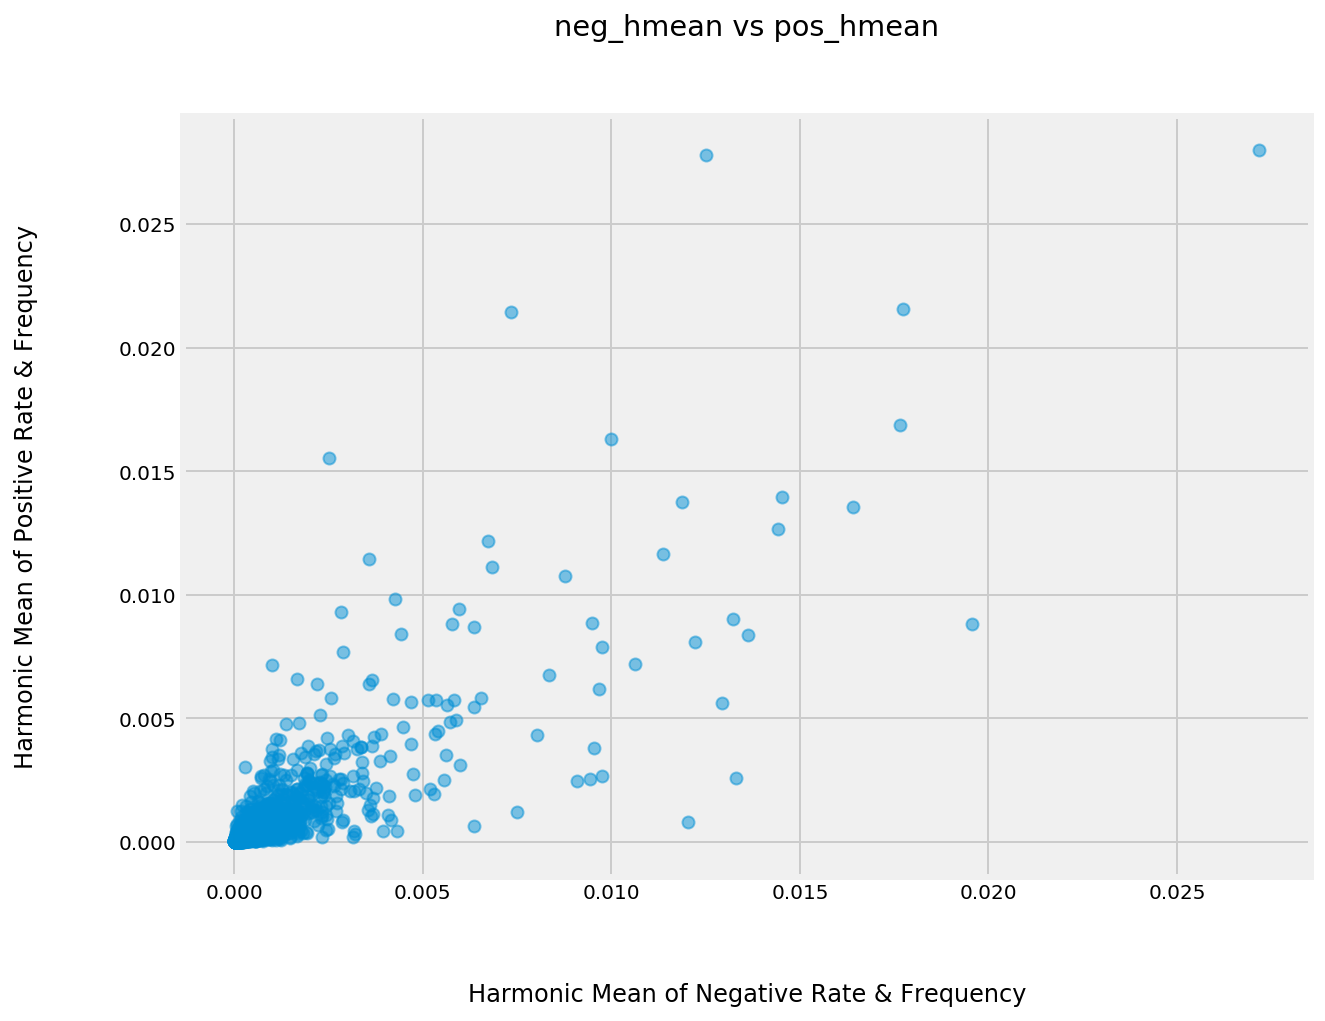

In [98]:
# Plot neg_hmean vs pos_hmean

plt.figure(figsize=(9,7))

ax = sns.regplot(x="neg_hmean", y="pos_hmean", fit_reg=False, scatter_kws={'alpha':0.5}, data=tf_df)

plt.xlabel('Harmonic Mean of Negative Rate & Frequency', labelpad=40)
plt.ylabel('Harmonic Mean of Positive Rate & Frequency', labelpad=40)

plt.title('neg_hmean vs pos_hmean', pad=40)


Text(0.5,1,'neg_norm_cdf_hmean vs pos_norm_cdf_hmean')

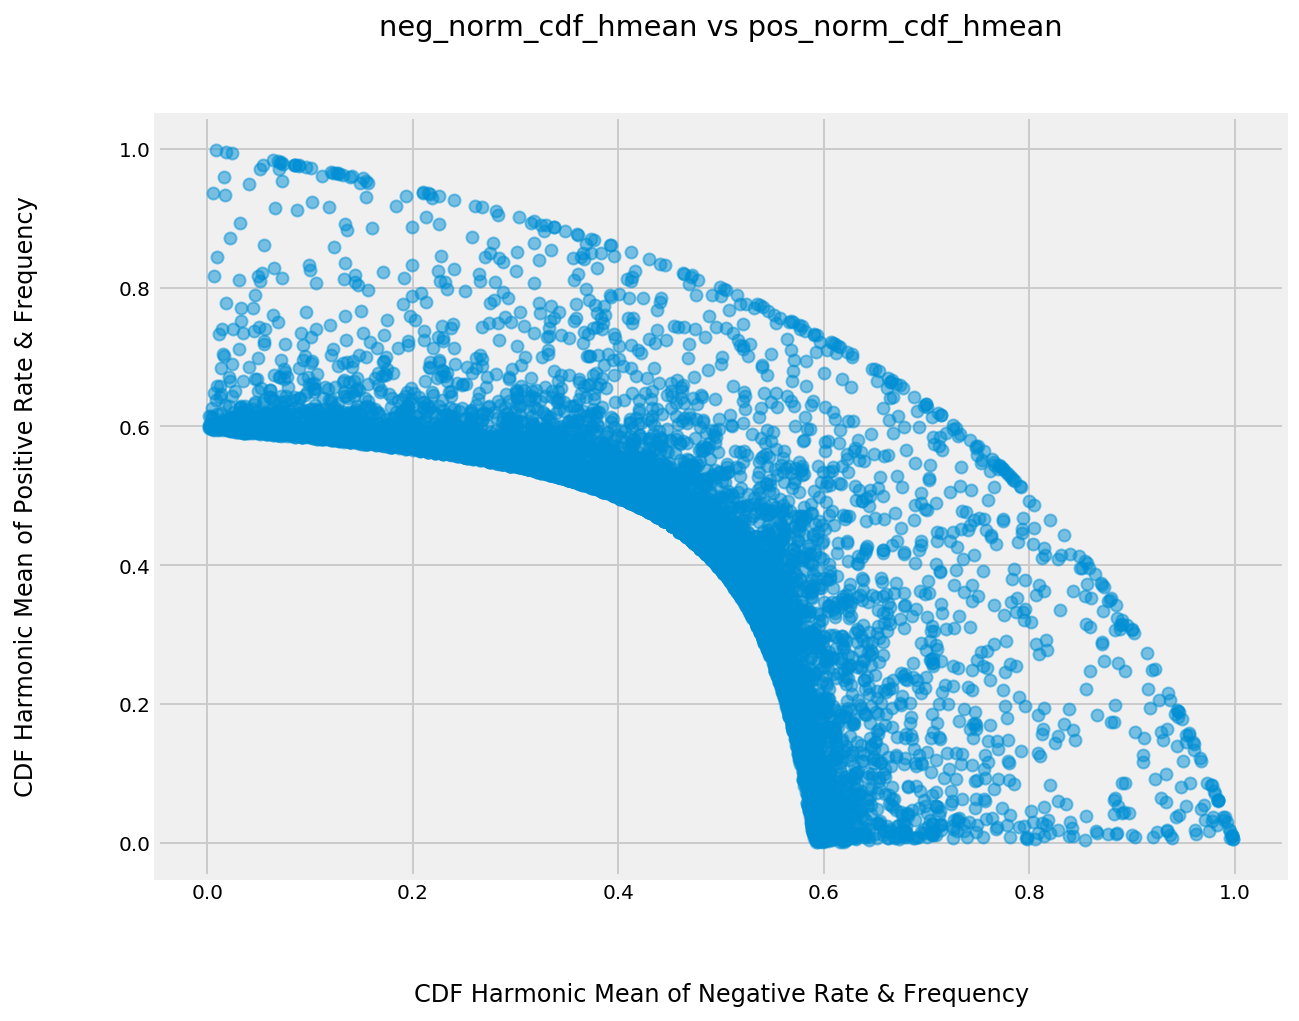

In [100]:
# Plot neg_norm_cdf_hmean vs pos_norm_cdf_hmean

plt.figure(figsize=(9,7))

ax = sns.regplot(x="neg_norm_cdf_hmean", y="pos_norm_cdf_hmean", fit_reg=False, scatter_kws={'alpha':0.5}, data=tf_df)

plt.xlabel('CDF Harmonic Mean of Negative Rate & Frequency', labelpad=40)
plt.ylabel('CDF Harmonic Mean of Positive Rate & Frequency', labelpad=40)

plt.title('neg_norm_cdf_hmean vs pos_norm_cdf_hmean', pad=40)


#### It is good that the metric has created some meaningful insight out of frequency but to avoid messy annotation & representation of each word token, It's better to use an interactive visualisation library.
#### Bokeh creates graphics in the style of D3.js.

In [104]:
# Bokeh graphics

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper

# HTML or Notebook output, mapping color according to pos_norm_cdf_hmean
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(tf_df.pos_norm_cdf_hmean), high=max(tf_df.pos_norm_cdf_hmean))

# Labelling & plotting circle
bplt = figure(x_axis_label='neg_norm_cdf_hmean', y_axis_label='pos_norm_cdf_hmean')
bplt.circle('neg_norm_cdf_hmean', 'pos_norm_cdf_hmean', size=5, alpha=0.3, source=tf_df, color={'field': 'pos_norm_cdf_hmean', 'transform': color_mapper})

# Hover visulization
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[('token', '@index')])
bplt.add_tools(hover)

show(bplt)

Loading BokehJS ...

Positive to Negative :: Color Changes as Yellow => Orange => Purple => Black

### Zipf's Law
#### In a corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.

$${f(r)} \propto \frac{1}{r^\alpha}$$

Text(0.5,1,'Top 500 ranking tokens in tweets')

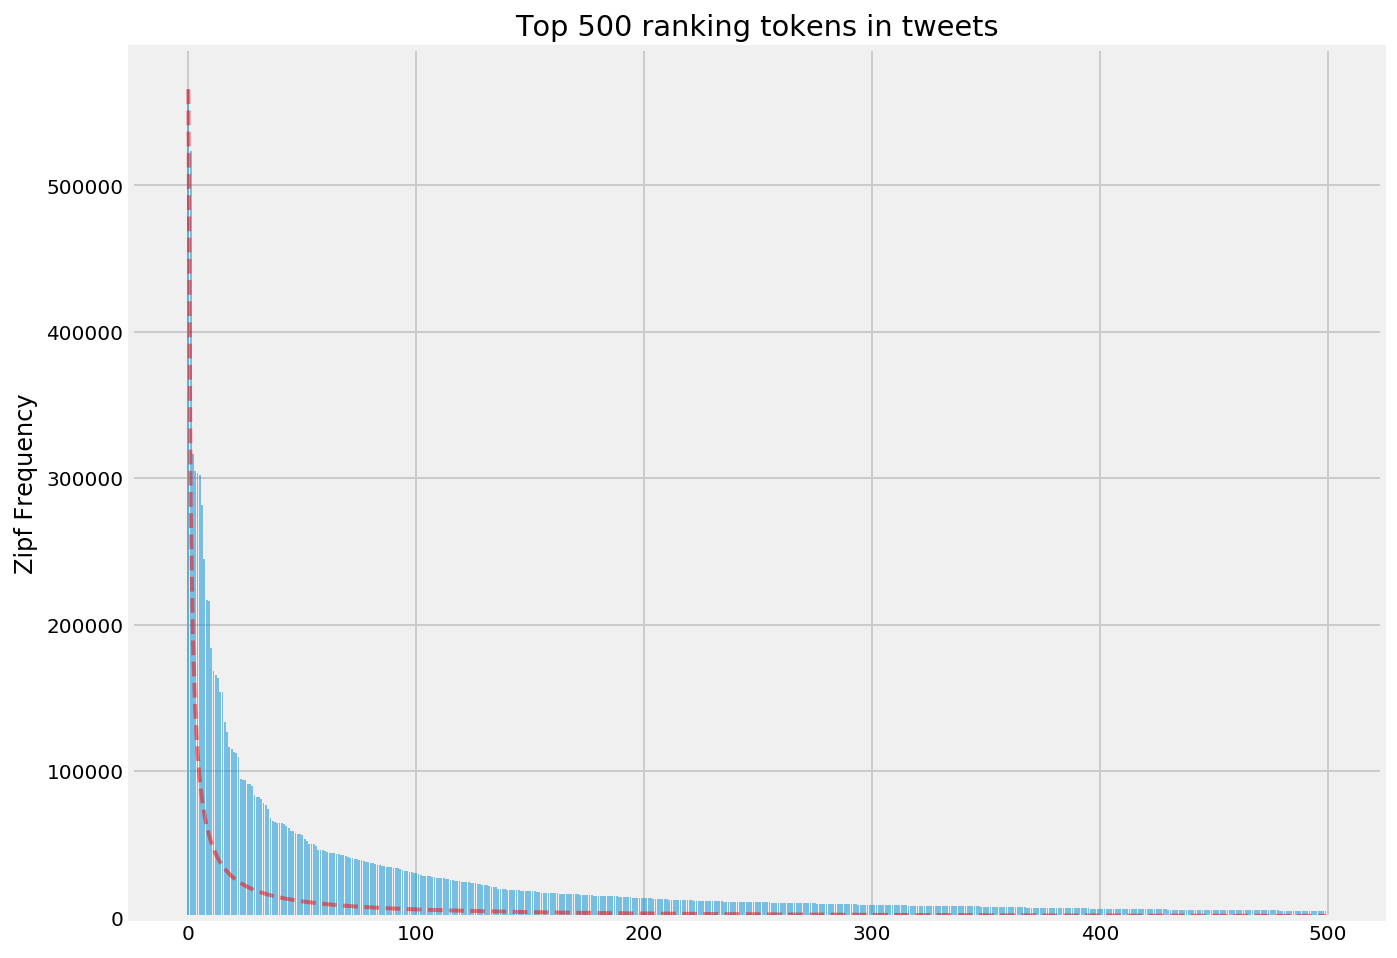

In [73]:
# Visualizing Zipf frequency law on our data

rank = np.arange(500)
plt.figure(figsize=(10,8))

exp = 1
zipf_freq = [tf_df.sort_values(by='total', ascending=False)['total'][0] / (r+1)**exp for r in rank]

plt.bar(rank, tf_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(rank, zipf_freq, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Zipf Frequency')
plt.title('Top 500 ranking tokens in tweets')

In [122]:
list(np.logspace(-0.5, np.log10(len(tf_df.total)-100000), 25).astype(int))

[0,
 0,
 1,
 1,
 3,
 6,
 11,
 21,
 38,
 70,
 129,
 235,
 429,
 784,
 1430,
 2610,
 4761,
 8687,
 15849,
 28914,
 52751,
 96237,
 175572,
 320307,
 584357]

In [115]:
freq_index

00                        613861
000                       600797
0000                      433663
00000                     300094
000000000000               68527
0000001                   675497
000001                    452789
000014                    299013
00004873337e0033fea60     293405
00009                     235685
0000ff                    458032
0000r0cx                  462013
0001110101001010000111    600330
0001t                     402259
0003                      563436
0007                      269160
000aah                    124252
000albums                 330392
000followers              192926
000follows                658180
000ft                      95144
000g                       82734
000gbp                    648494
000h                      607680
000hagds                  453592
000hrs                    128986
000ish                    634734
000k                      255508
000kg                     177229
000km                      61704
          

In [103]:
tf_df.index

Index(['00', '000', '0000', '00000', '000000000000', '0000001', '000001',
       '000014', '00004873337e0033fea60', '00009',
       ...
       'ø¹ø', 'ø¹øª', 'ø¹ø³ù', 'ø¹øµø', 'ø¹ù', 'øºø', 'øºøµ', 'øºøµø', 'øºù',
       'ù¾ø'],
      dtype='object', length=684358)

IndexError: range object index out of range

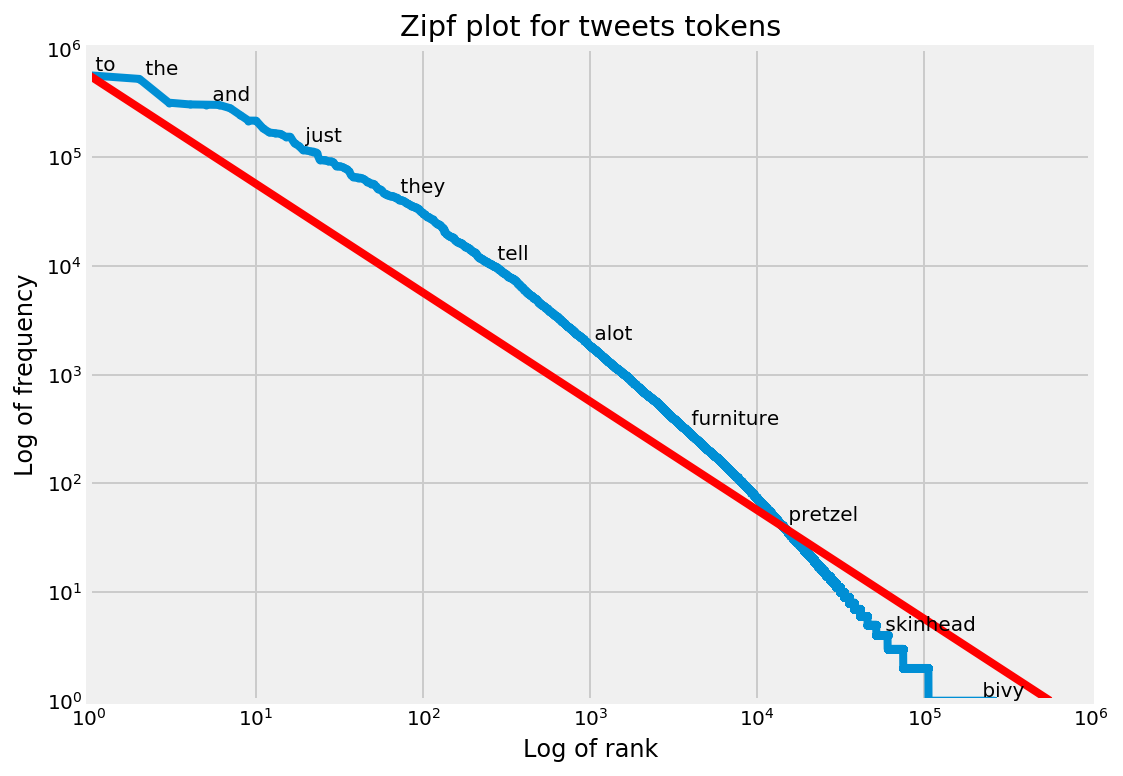

In [126]:
# Calculating ranks, frequencies of the token words

ranks = range(1, len(tf_df.index)+1)
frequencies = tf_df.total[np.argsort(-tf_df.total)]
#frequencies = tf_df.sort_values(by=['total'], ascending=False)['total']

plt.figure(figsize=(8,6))
plt.ylim(1, 10**6)
plt.xlim(1, 10**6)

plt.loglog(ranks, frequencies, marker=".")
plt.plot([1, frequencies[0]], [frequencies[0], 1], color='r')
plt.title("Zipf plot for tweets tokens")
plt.xlabel("Log of rank")
plt.ylabel("Log of frequency")
plt.grid(True)

freq_index = np.argsort(-tf_df.total)
for lgidx in list(np.logspace(-0.5, np.log(len(tf_df.index)-2), 25).astype(int)):
    plt.text(ranks[lgidx], frequencies[lgidx], " " + tf_df.index[freq_index[lgidx]], verticalalignment="bottom", horizontalalignment="left")


In [ ]:
from pylab import *
counts = tf_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [ ]:
# Calculating ranks, frequencies of the token words

ranks = range(1, len(tf_df.index)+1)
frequencies = tf_df.sort_values(by=['total'], ascending=False)['total']

plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)

plt.loglog(ranks, frequencies, marker=".")
plt.plot([1, frequencies[0]], [frequencies[0], 1], color='r')
plt.title("Zipf plot for tweets tokens")
plt.xlabel("Frequency rank of token")
plt.ylabel("Absolute frequency of token")
plt.grid(True)

### Twitter API Usage

In [ ]:
import tweepy
import hidden
import sqlite3
from langdetect import detect

In [ ]:
# Authenticating & establishing a connection with twitter

auth = tweepy.OAuthHandler(hidden.consumer_key, hidden.consumer_secret)
auth.set_access_token(hidden.token_key, hidden.token_secret)
api = tweepy.API(auth)

In [ ]:
# Location based search

places = api.geo_search(query="London", granularity="city")
place_id = places[0].id

# Query for tweets
max_tweet = 10
for tweet in tweepy.Cursor(api.search, q="place:%s" % place_id).items(maxitems):
    print tweet.text


#### SQL lite to store the data

In [ ]:
# Establishing connection & creating table to store tweets

conn = sqlite3.connect('twitter_testing.sqlite')
cur = conn.cursor()
cur.executescript('''

CREATE TABLE Tweets_London (
    id     INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    user_id TEXT,
    user_name TEXT,
    user_timezone TEXT,
    user_language TEXT,
    detected_language TEXT,
    tweet_text  TEXT,
    tweet_created TEXT
)
''')

In [ ]:
# Query for tweets

for tweet in tweepy.Cursor(api.search, q="place:%s" % place_id).items(maxitems):
    # Language detection
    detected = detect(tweet.text)
    cur.execute('''INSERT OR IGNORE INTO Tweets_London (user_id, user_name, user_timezone, user_language, detected_language, tweet_text, tweet_created) 
                          VALUES ( ?,?,?,?,?,?,? )''', (tweet.user.id,tweet.user.screen_name,tweet.user.time_zone,tweet.user.lang,detected,tweet.text,tweet.created_at))
    conn.commit()
    
# Querying sql database
from_sql = pd.read_sql_query("SELECT * FROM Tweets_London;", conn)
display(from_sql)

In [ ]:
https://github.com/tthustla/twitter_sentiment_analysis_part4/blob/master/Capstone_part4-Copy2.ipynb

In [3]:
# Read TF dataframe

df = pd.read_hdf('./data/redstone.hdf')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
sentiment        1600000 non-null int64
text             1600000 non-null object
pre_clean_len    1600000 non-null int64
dtypes: int64(2), object(1)
memory usage: 48.8+ MB


sentiment                                               text  pre_clean_len
0          0  awww that bummer you shoulda got david carr of...            115
1          0  is upset that he can not update his facebook b...            111
2          0  dived many times for the ball managed to save ...             89
3          0     my whole body feels itchy and like its on fire             47
4          0  no it not behaving at all mad why am here beca...            111

In [4]:
# Santitizing dataframe

df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
sentiment        1600000 non-null int64
text             1600000 non-null object
pre_clean_len    1600000 non-null int64
dtypes: int64(2), object(1)
memory usage: 36.6+ MB


In [5]:
from sklearn.cross_validation import train_test_split

train = df.text
label = df.sentiment
SEED = 21

# Splitting data into train, test & validation sets
x_train, x_val_test, y_train, y_val_test = train_test_split(train, label, test_size=.02, random_state=SEED)

x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=.5, random_state=SEED)

/home/indiano/miniconda3/envs/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from collections import Counter

counter = Counter(y_train)
print('Train set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Negative Entries'.format( (counter[key]/len(y_train))*100 ))
    elif key == 1:
        print('{:.2f}% Positive Entries'.format( (counter[key]/len(y_train))*100 ))
        
counter = Counter(y_val)
print('\nValidation set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Negative Entries'.format( (counter[key]/len(y_val))*100 ))
    elif key == 1:
        print('{:.2f}% Positive Entries'.format( (counter[key]/len(y_val))*100 ))

counter = Counter(y_test)
print('\nTest set entries.')
for key in counter:
    if key == 0:
        print('{:.2f}% Negative Entries'.format( (counter[key]/len(y_test))*100 ))
    elif key == 1:
        print('{:.2f}% Positive Entries'.format( (counter[key]/len(y_test))*100 ))

Train set entries.
50.00% Negative Entries
50.00% Positive Entries

Validation set entries.
50.01% Negative Entries
49.99% Positive Entries

Test set entries.
50.21% Negative Entries
49.79% Positive Entries


### Baseline Performance

ZeroR classifier simply predicts the majority category
Based on validation set, 50.01% accuracy for negative class & 49.99% for postive class.

In [ ]:
Text Blob sentiment analysis

In [6]:
# Textblob import

from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
%%time

# Sentiment calculation
polarity = [TextBlob(val).sentiment.polarity for val in x_val]
tb_pred = [1 if polar > 0 else 0 for polar in polarity]

CPU times: user 6.28 s, sys: 20 ms, total: 6.3 s
Wall time: 6.31 s


In [8]:
# Confusion_matrix, labels order 1, 0

fusion = confusion_matrix(y_val, tb_pred, labels=[1, 0])
fusion_df = pd.DataFrame(fusion, index=['positive', 'negative'], columns=['predicted_positive','predicted_negative'])

print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_val, tb_pred)*100))
print('-'*89)
print('\nConfusion Matrix\n{}'.format(fusion_df))
print('-'*89)
print('\nClassification Report\n{}'.format(classification_report(y_val, tb_pred)))

Accuracy Score: 63.33%
-----------------------------------------------------------------------------------------

Confusion Matrix
          predicted_positive  predicted_negative
positive                4521                3477
negative                2390                5612
-----------------------------------------------------------------------------------------

Classification Report
             precision    recall  f1-score   support

          0       0.62      0.70      0.66      8002
          1       0.65      0.57      0.61      7998

avg / total       0.64      0.63      0.63     16000



### Feature Extraction

The bag of words model ignores grammar and order of words. 

In [ ]:
# Logistic Regression with Count Vectorizer

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from datetime import datetime
from collections import Counter

In [78]:
# Calculate accuracy & summmary of different set of features

def accuracy_features(pipeline, x_train, y_train, x_test, y_test):
    
    counter = Counter(y_test)

    if (counter[0] / (len(y_test)*1.)) > 0.5:
        baseline_accuracy = counter[0] / (len(y_test)*1.)
    else:
        baseline_accuracy = 1. - (counter[0] / (len(y_test)*1.))
   
    # Timer starts
    timer = datetime.now()
    
    model = pipeline.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    elapsed_time = datetime.now() - timer
    # Timer stops

    accuracy = accuracy_score(y_test, y_pred)
    
    
    print('Baseline accuracy: {:.2f}%'.format(baseline_accuracy*100))
    print('Accuracy score: {:.2f}%'.format(accuracy*100))
    
    if(accuracy > baseline_accuracy):
        print('\nModel accuracy:{:.2f}% - Baseline accuracy:{:.2f}%: Increase of {:.2f}%'.format(accuracy*100, baseline_accuracy*100, (accuracy-baseline_accuracy)*100))
    else:
        print('Model accuracy:{:.2f}% - Baseline accuracy:{:.2f}%: Decrease of {:.2f}%'.format(accuracy*100, baseline_accuracy*100, (accuracy-baseline_accuracy)*100))
    
    print('Overall Train and Prediction time: {:.2f}s'.format(elapsed_time.total_seconds()))
    print('-'*89)
          
    return accuracy, elapsed_time

In [17]:
# timer = datetime.now()
# print('odd*1000')
# elapsed_time = datetime.now() - timer
# print(elapsed_time)
# print('Overall Train and Prediction time: {}s'.format(elapsed_time.total_seconds()))


In [18]:
# Feature extraction, Iteratively

# Count Vectorizer, Logistic Regression model
cvec = CountVectorizer()
lr = LogisticRegression()

n_features = np.arange(10000, 100001, 10000)

def feature_extraction(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)

    for features in n_features:
        # Setting vectorizer parameters & creating pipeline
        cvec.set_params(stop_words=stop_words, max_features=features, ngram_range=ngram_range)
        pipeline = Pipeline([
            ('vectorizer', cvec),
            ('classifier', classifier)
        ])
        print("\nValidation result for {} features".format(features))
        
        # Calculate accuracy & summmary
        features_accuracy, features_time = accuracy_features(pipeline, x_train, y_train, x_val, y_val)
        result.append((features, features_accuracy, features_time))
        
    return result

#### Unigram

In [19]:
%%time

print('Result for UNIGRAM without STOP words\n')
feature_res_nostop = feature_extraction(stop_words='english')

Result for UNIGRAM without STOP words

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 77.19%

Model accuracy: 77.19% Baseline accuracy: 50.01% Increase of 27.18%
Overall Train and Prediction time: 42.34s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 77.17%

Model accuracy: 77.17% Baseline accuracy: 50.01% Increase of 27.16%
Overall Train and Prediction time: 45.69s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 77.14%

Model accuracy: 77.14% Baseline 

In [20]:
%%time

print('Result for UNIGRAM with STOP words\n')
feature_res_stop = feature_extraction()

Result for UNIGRAM with STOP words

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 79.61%

Model accuracy: 79.61% Baseline accuracy: 50.01% Increase of 29.60%
Overall Train and Prediction time: 70.55s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 79.53%

Model accuracy: 79.53% Baseline accuracy: 50.01% Increase of 29.52%
Overall Train and Prediction time: 99.80s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 79.67%

Model accuracy: 79.67% Baseline acc

In [26]:
# Read TF dataframe

tf_df = pd.read_csv('./data/tfidf.csv')

tf_df.sort_values(by='total', ascending=False).iloc[:10]

Unnamed: 0  negative  positive   total
613861         to    313162    252567  565729
600797        the    257836    265998  523834
433663         my    190775    125955  316730
300094         it    157448    147786  305234
68527         and    153958    149642  303600
675497        you    103844    198245  302089
452789        not    194724     86861  281585
299013         is    133432    111191  244623
293405         in    115542    101160  216702
235685        for     98999    117369  216368

In [31]:
from sklearn.feature_extraction import text

# Top 10 words in tf-idf 
my_stop_words = frozenset(list(tf_df.sort_values(by='total', ascending=False).iloc[:10].index))

# Check top 10 words in tf-idf are present in english stop words
set(my_stop_words).issubset(set(text.ENGLISH_STOP_WORDS))

False

In [32]:
%%time

print('Result for UNIGRAM with custom STOP words\n')
feature_res_mystop = feature_extraction(stop_words=my_stop_words)

Result for UNIGRAM with custom STOP words

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 79.61%

Model accuracy: 79.61% Baseline accuracy: 50.01% Increase of 29.60%
Overall Train and Prediction time: 76.37s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 79.53%

Model accuracy: 79.53% Baseline accuracy: 50.01% Increase of 29.52%
Overall Train and Prediction time: 97.54s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 79.67%

Model accuracy: 79.67% Basel

In [ ]:
# Debug to check the third plot

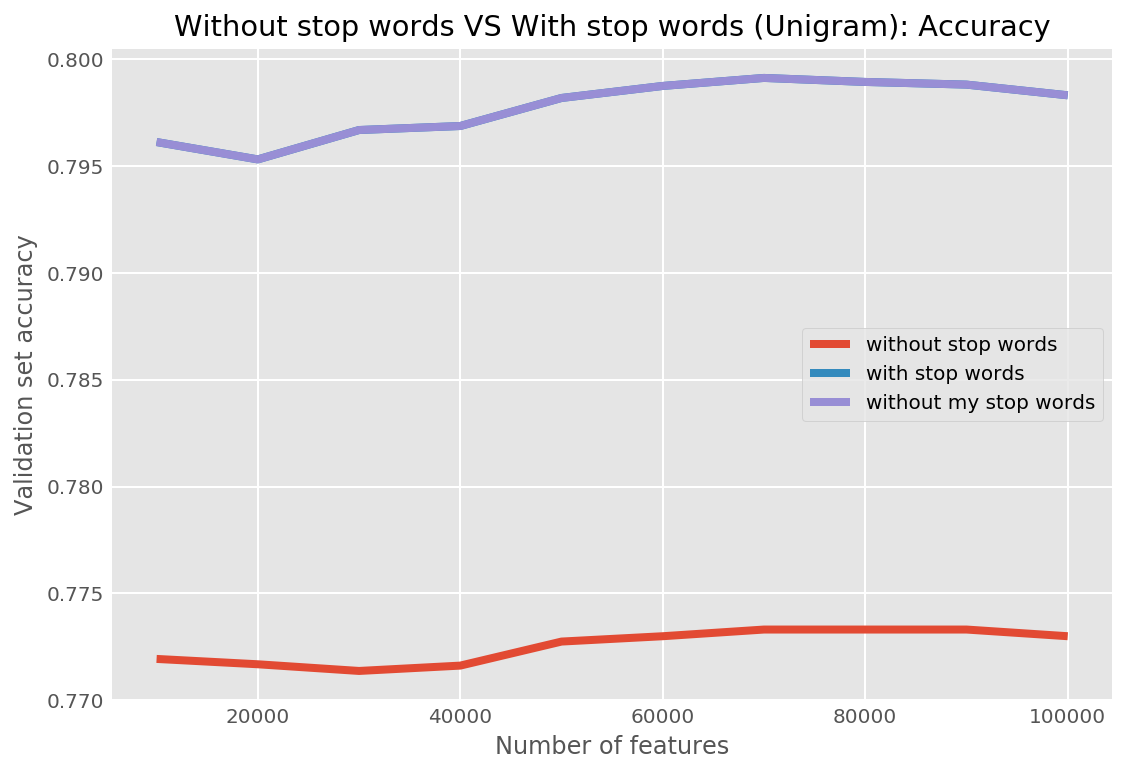

In [57]:
# Dataframes feature extraction results for without stop, with stop & custom stop words 
# features_res_unigram = features_nostop
features_nostop = pd.DataFrame(feature_res_nostop, columns=['features', 'features_accuracy', 'features_time'])
features_stop = pd.DataFrame(feature_res_stop, columns=['features', 'features_accuracy', 'features_time'])
features_mystop = pd.DataFrame(feature_res_mystop, columns=['features', 'features_accuracy', 'features_time'])

plt.style.use('ggplot')
# Plot the results
plt.figure(figsize=(8,6))

plt.plot(features_nostop.features, features_nostop.features_accuracy, label='without stop words')
plt.plot(features_stop.features, features_stop.features_accuracy, label='with stop words')
plt.plot(features_mystop.features, features_mystop.features_accuracy, label='without my stop words')

plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")

plt.legend()

In [ ]:
#### Bigram

In [47]:
%%time

print('Result for Bigram with STOP words\n')
feature_res_bigram = feature_extraction(ngram_range=(1, 2))

Result for Bigram with custom STOP words

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 80.59%

Model accuracy: 80.59% Baseline accuracy: 50.01% Increase of 30.58%
Overall Train and Prediction time: 126.01s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 81.26%

Model accuracy: 81.26% Baseline accuracy: 50.01% Increase of 31.24%
Overall Train and Prediction time: 142.46s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 81.77%

Model accuracy: 81.77% Base

In [51]:
#### Trigram

In [52]:
%%time

print('Result for Trigram with STOP words\n')
feature_res_trigram = feature_extraction(ngram_range=(1, 3))

Result for Trigram with STOP words

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 80.29%

Model accuracy: 80.29% Baseline accuracy: 50.01% Increase of 30.28%
Overall Train and Prediction time: 217.84s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 81.25%

Model accuracy: 81.25% Baseline accuracy: 50.01% Increase of 31.24%
Overall Train and Prediction time: 216.74s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 81.90%

Model accuracy: 81.90% Baseline a

In [53]:
import pickle

with open('./data/features_nostop.pkl', 'wb') as file:
    pickle.dump(features_nostop, file)
    
with open('./data/feature_res_bigram.pkl', 'wb') as file:
    pickle.dump(feature_res_bigram, file)
    
with open('./data/feature_res_trigram.pkl', 'wb') as file:
    pickle.dump(feature_res_trigram, file)

print('File dumped')

File dumped


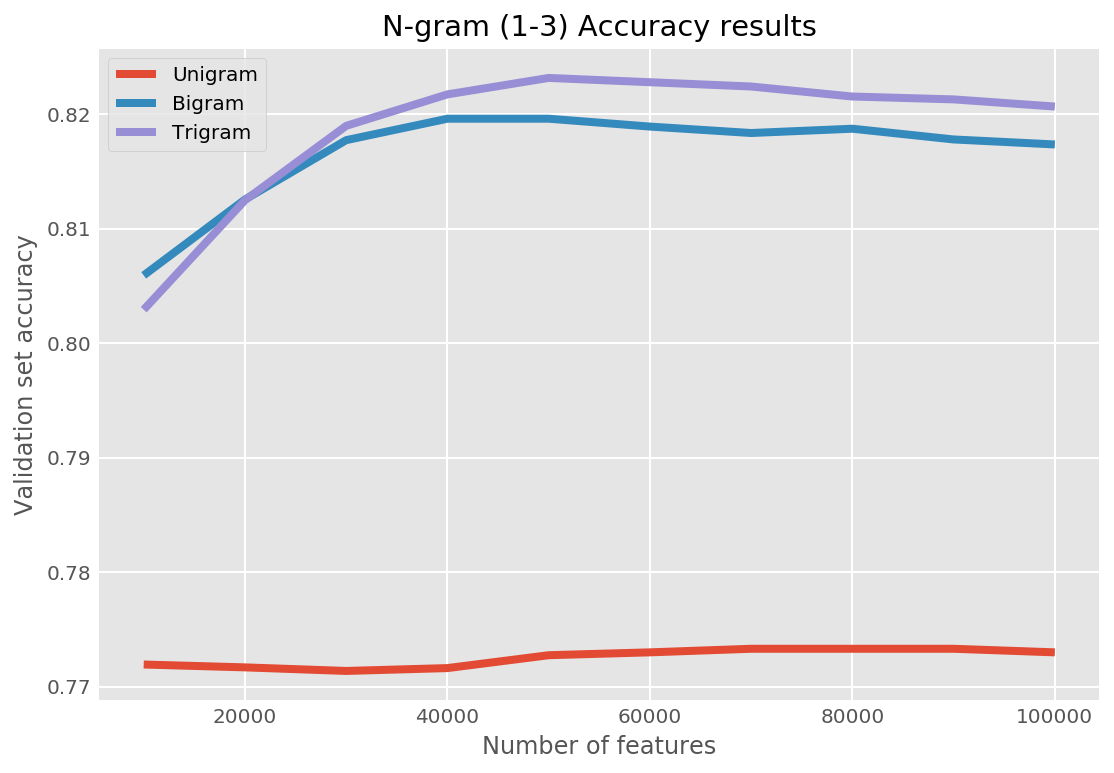

In [54]:
# Dataframes feature extraction results for without stop, with stop & custom stop words 

features_unigram = pd.DataFrame(feature_res_nostop, columns=['features', 'features_accuracy', 'features_time'])
feature_bigram = pd.DataFrame(feature_res_bigram, columns=['features', 'features_accuracy', 'features_time'])
feature_trigram = pd.DataFrame(feature_res_trigram, columns=['features', 'features_accuracy', 'features_time'])

# Plot the results
plt.figure(figsize=(8,6))

plt.plot(features_unigram.features, features_unigram.features_accuracy, label='Unigram')
plt.plot(feature_bigram.features, feature_bigram.features_accuracy, label='Bigram')
plt.plot(feature_trigram.features, feature_trigram.features_accuracy, label='Trigram')

plt.title("N-gram (1-3) Accuracy results")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")

plt.legend()

In [63]:
# Updated accuracy function, Calculate accuracy & summmary of different set of features

def accuracy_features_fusion(pipeline, x_train, y_train, x_test, y_test):
    
    counter = Counter(y_test)

    if (counter[0] / (len(y_test)*1.)) > 0.5:
        baseline_accuracy = counter[0] / (len(y_test)*1.)
    else:
        baseline_accuracy = 1. - (counter[0] / (len(y_test)*1.))
   
    # Timer starts
    timer = datetime.now()
    
    model = pipeline.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    elapsed_time = datetime.now() - timer
    # Timer stops

    accuracy = accuracy_score(y_test, y_pred)
    
    # Confusion matrix
    fusion = np.array(confusion_matrix(y_test, y_pred, labels=[0, 1]))
    fusion_df = pd.DataFrame(fusion, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    
    print('Baseline accuracy: {:.2f}%'.format(baseline_accuracy*100))
    print('Accuracy score: {:.2f}%'.format(accuracy*100))
    
    if(accuracy > baseline_accuracy):
        print('\nModel accuracy:{:.2f}% - Baseline accuracy:{:.2f}%: Increase of {:.2f}%'.format(accuracy*100, baseline_accuracy*100, (accuracy-baseline_accuracy)*100))
    else:
        print('Model accuracy:{:.2f}% - Baseline accuracy:{:.2f}%: Decrease of {:.2f}%'.format(accuracy*100, baseline_accuracy*100, (accuracy-baseline_accuracy)*100))
    
    print('Overall Train and Prediction time: {:.2f}s'.format(elapsed_time.total_seconds()))
    print('-'*89)
    
    print('\nConfusion Matrix\n\n{}'.format(fusion_df))
    print('-'*89)
    
    classi_report = classification_report(y_test, y_pred, target_names=['negative', 'positive'])
    print('\nClassification Report\n\n{}'.format(classi_report))
    
    return accuracy, elapsed_time, fusion_df, classi_report

In [64]:
#### Unigram run with updated function

In [65]:
%%time
unigram_cvec = CountVectorizer(max_features=80000)
unigram_pipeline = Pipeline([
        ('vectorizer', unigram_cvec),
        ('classifier', lr)
    ])

# Run unigram feature extraction with updated function
accuracy, elapsed_time, fusion_df, classi_report = accuracy_features_fusion(unigram_pipeline, x_train, y_train, x_val, y_val)

Baseline accuracy: 50.01%
Accuracy score: 79.89%

Model accuracy:79.89% - Baseline accuracy:50.01%: Increase of 29.88%
Overall Train and Prediction time: 102.02s
-----------------------------------------------------------------------------------------

Confusion Matrix

          predicted_negative  predicted_positive
negative                6268                1734
positive                1483                6515
-----------------------------------------------------------------------------------------

Classification Report

             precision    recall  f1-score   support

   negative       0.81      0.78      0.80      8002
   positive       0.79      0.81      0.80      7998

avg / total       0.80      0.80      0.80     16000

CPU times: user 1min 42s, sys: 0 ns, total: 1min 42s
Wall time: 1min 42s


In [66]:
#### Bigram run with updated function

In [67]:
%%time
bigram_cvec = CountVectorizer(max_features=40000)
bigram_pipeline = Pipeline([
        ('vectorizer', bigram_cvec),
        ('classifier', lr)
    ])

# Run bigram feature extraction with updated function
accuracy, elapsed_time, fusion_df, classi_report = accuracy_features_fusion(bigram_pipeline, x_train, y_train, x_val, y_val)

Baseline accuracy: 50.01%
Accuracy score: 79.69%

Model accuracy:79.69% - Baseline accuracy:50.01%: Increase of 29.67%
Overall Train and Prediction time: 108.80s
-----------------------------------------------------------------------------------------

Confusion Matrix

          predicted_negative  predicted_positive
negative                6245                1757
positive                1493                6505
-----------------------------------------------------------------------------------------

Classification Report

             precision    recall  f1-score   support

   negative       0.81      0.78      0.79      8002
   positive       0.79      0.81      0.80      7998

avg / total       0.80      0.80      0.80     16000

CPU times: user 1min 48s, sys: 4 ms, total: 1min 48s
Wall time: 1min 48s


In [ ]:
#### Trigram run with updated function

In [68]:
%%time
trigram_cvec = CountVectorizer(max_features=50000)
trigram_pipeline = Pipeline([
        ('vectorizer', trigram_cvec),
        ('classifier', lr)
    ])

# Run trigram feature extraction with updated function
accuracy, elapsed_time, fusion_df, classi_report = accuracy_features_fusion(trigram_pipeline, x_train, y_train, x_val, y_val)

Baseline accuracy: 50.01%
Accuracy score: 79.82%

Model accuracy:79.82% - Baseline accuracy:50.01%: Increase of 29.81%
Overall Train and Prediction time: 98.39s
-----------------------------------------------------------------------------------------

Confusion Matrix

          predicted_negative  predicted_positive
negative                6257                1745
positive                1484                6514
-----------------------------------------------------------------------------------------

Classification Report

             precision    recall  f1-score   support

   negative       0.81      0.78      0.79      8002
   positive       0.79      0.81      0.80      7998

avg / total       0.80      0.80      0.80     16000

CPU times: user 1min 38s, sys: 3.99 ms, total: 1min 38s
Wall time: 1min 38s


In [ ]:
#### TF-IDF vectorizer, used first time in the exercise

In [69]:
# Tfidf Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [70]:
#### Unigram with TF-IDF vectorizer

In [71]:
%%time

print('Result for UNIGRAM with STOP words, TF-IDF vectorizer\n')
feature_res_stop_uni_tf = feature_extraction(vectorizer=tvec)

Result for UNIGRAM with STOP words, TF-IDF vectorizer

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 79.61%

Model accuracy: 79.61% Baseline accuracy: 50.01% Increase of 29.60%
Overall Train and Prediction time: 72.37s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 79.53%

Model accuracy: 79.53% Baseline accuracy: 50.01% Increase of 29.52%
Overall Train and Prediction time: 92.61s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 79.67%

Model accuracy: 

In [73]:
#### Bigram with TF-IDF vectorizer

In [74]:
%%time

print('Result for BIGRAM with STOP words, TF-IDF vectorizer\n')
feature_res_stop_bi_tf = feature_extraction(vectorizer=tvec, ngram_range=(1, 2))

Result for BIGRAM with STOP words, TF-IDF vectorizer

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 80.59%

Model accuracy: 80.59% Baseline accuracy: 50.01% Increase of 30.58%
Overall Train and Prediction time: 122.83s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 81.26%

Model accuracy: 81.26% Baseline accuracy: 50.01% Increase of 31.24%
Overall Train and Prediction time: 136.00s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 81.77%

Model accuracy:

In [75]:
#### Trigram with TF-IDF vectorizer

In [76]:
%%time

print('Result for TRIGRAM with STOP words, TF-IDF vectorizer\n')
feature_res_stop_tri_tf = feature_extraction(vectorizer=tvec, ngram_range=(1, 3))

Result for TRIGRAM with STOP words, TF-IDF vectorizer

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Validation result for 10000 features
Baseline accuracy: 50.01%
Accuracy score: 80.29%

Model accuracy: 80.29% Baseline accuracy: 50.01% Increase of 30.28%
Overall Train and Prediction time: 209.64s
-----------------------------------------------------------------------------------------

Validation result for 20000 features
Baseline accuracy: 50.01%
Accuracy score: 81.25%

Model accuracy: 81.25% Baseline accuracy: 50.01% Increase of 31.24%
Overall Train and Prediction time: 212.79s
-----------------------------------------------------------------------------------------

Validation result for 30000 features
Baseline accuracy: 50.01%
Accuracy score: 81.90%

Model accuracy

In [77]:
# Saving extracted features as pickle 

with open('./data/feature_res_stop_uni_tf.pkl', 'wb') as file:
    pickle.dump(feature_res_stop_uni_tf, file)
    
with open('./data/feature_res_stop_bi_tf.pkl', 'wb') as file:
    pickle.dump(feature_res_stop_bi_tf, file)
    
with open('./data/feature_res_stop_tri_tf.pkl', 'wb') as file:
    pickle.dump(feature_res_stop_tri_tf, file)

print('File dumped')

File dumped


In [ ]:
Debug other two plots

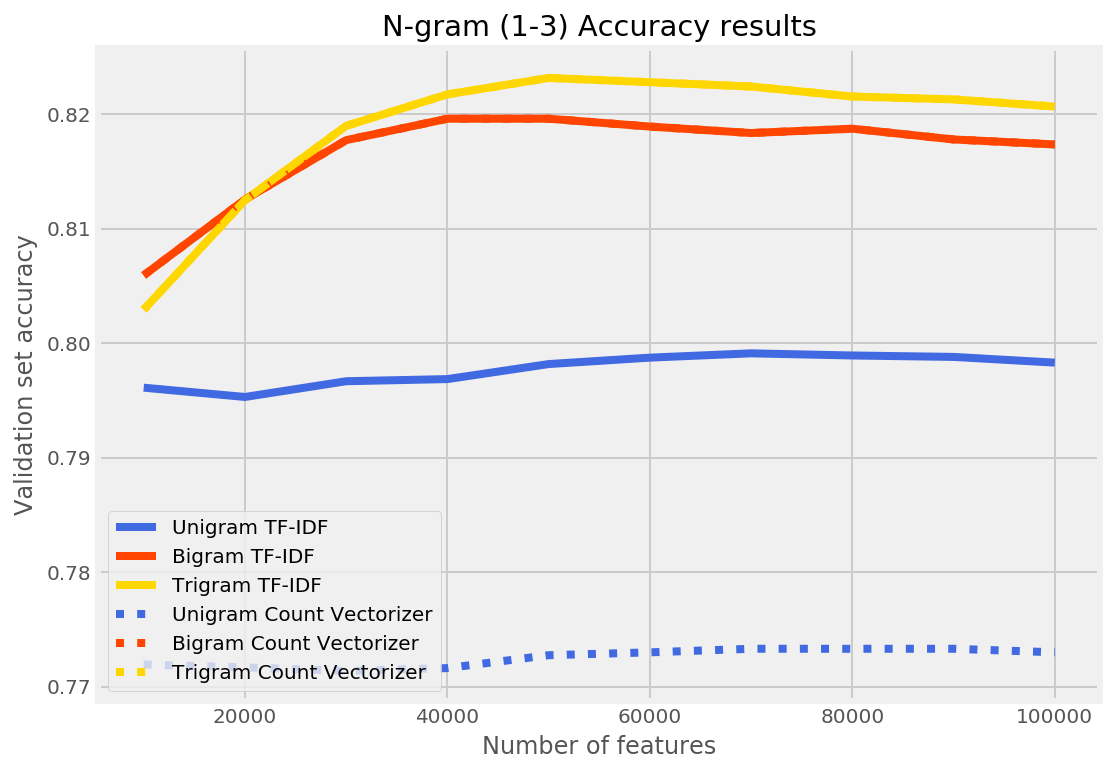

In [91]:
# Dataframes feature extraction results for without stop, with stop & custom stop words 

features_unigram_tf = pd.DataFrame(feature_res_stop_uni_tf, columns=['features', 'features_accuracy', 'features_time'])
feature_bigram_tf = pd.DataFrame(feature_res_stop_bi_tf, columns=['features', 'features_accuracy', 'features_time'])
feature_trigram_tf = pd.DataFrame(feature_res_stop_tri_tf, columns=['features', 'features_accuracy', 'features_time'])

# Plot the results
plt.figure(figsize=(8,6))

plt.plot(features_unigram_tf.features, features_unigram_tf.features_accuracy, label='Unigram TF-IDF', color='royalblue')
plt.plot(feature_bigram_tf.features, feature_bigram_tf.features_accuracy, label='Bigram TF-IDF', color='orangered')
plt.plot(feature_trigram_tf.features, feature_trigram_tf.features_accuracy, label='Trigram TF-IDF', color='gold')

plt.plot(features_unigram.features, features_unigram.features_accuracy, label='Unigram Count Vectorizer', linestyle=':', color='royalblue')
plt.plot(feature_bigram.features, feature_bigram.features_accuracy, label='Bigram Count Vectorizer', linestyle=':', color='orangered')
plt.plot(feature_trigram.features, feature_trigram.features_accuracy, label='Trigram Count Vectorizer', linestyle=':', color='gold')

plt.title("N-gram (1-3) Accuracy results")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")

plt.legend()

In [86]:
feature_bigram[0:10]
feature_trigram[0:10]

features  features_accuracy   features_time
0     10000           0.802937 00:03:37.842504
1     20000           0.812500 00:03:36.742764
2     30000           0.819000 00:03:33.525941
3     40000           0.821750 00:05:06.046641
4     50000           0.823187 00:04:41.418432
5     60000           0.822812 00:04:57.270947
6     70000           0.822438 00:04:30.953950
7     80000           0.821562 00:04:40.513486
8     90000           0.821313 00:05:25.598352
9    100000           0.820688 00:05:09.345725

### Algorithms Comparison

In [92]:
# Basic imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

# Classifiers names list
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron", "Passive-Aggresive", "Nearest Centroid"]

classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]

# Zipping all of them together
zipped_clf = zip(names,classifiers)

In [93]:
# Comparing different classifiers using pipeline
tvec = TfidfVectorizer()

def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    
    # Setting vectorizer parameters 
    tvec.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
   
    for clf_name, clf in zipped_clf:
        pipeline = Pipeline([
            ('vectorizer', tvec),
            ('classifier', clf)
        ])
        
        print("\nValidation result for {} classifier".format(clf_name))
        print(clf)
        
        # Calculate accuracy & summmary
        clf_accuracy, clf_time = accuracy_features(pipeline, x_train, y_train, x_val, y_val)
        result.append((clf_name, clf_accuracy, clf_time))
        
    return result

In [94]:
#### Trigram with different classifiers

In [95]:
%%time

print('Result for TRIGRAM with STOP words, Different Classifiers\n')
clf_trigram_res = classifier_comparator(vectorizer=tvec, ngram_range=(1, 3))

Result for TRIGRAM with STOP words, Different Classifiers


Validation result for Logistic Regression classifier
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Baseline accuracy: 50.01%
Accuracy score: 80.47%

Model accuracy:80.47% - Baseline accuracy:50.01%: Increase of 30.46%
Overall Train and Prediction time: 136.20s
-----------------------------------------------------------------------------------------

Validation result for Linear SVC classifier
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Baseline accuracy: 50.01%
Accuracy score: 80.34%

Model accuracy:80.34% - Baseline accuracy:50.01%: Increase o

/home/indiano/miniconda3/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Baseline accuracy: 50.01%
Accuracy score: 72.81%

Model accuracy:72.81% - Baseline accuracy:50.01%: Increase of 22.79%
Overall Train and Prediction time: 118.93s
-----------------------------------------------------------------------------------------

Validation result for Passive-Aggresive classifier
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


/home/indiano/miniconda3/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Baseline accuracy: 50.01%
Accuracy score: 76.71%

Model accuracy:76.71% - Baseline accuracy:50.01%: Increase of 26.69%
Overall Train and Prediction time: 118.49s
-----------------------------------------------------------------------------------------

Validation result for Nearest Centroid classifier
NearestCentroid(metric='euclidean', shrink_threshold=None)
Baseline accuracy: 50.01%
Accuracy score: 72.18%

Model accuracy:72.18% - Baseline accuracy:50.01%: Increase of 22.17%
Overall Train and Prediction time: 116.66s
-----------------------------------------------------------------------------------------
CPU times: user 29min 48s, sys: 14.7 s, total: 30min 3s
Wall time: 30min 3s


In [96]:
### Ensemble models

In [97]:
# 5 Ensemble models
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf_name, clf in zip(['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble'], [clf1, clf2, clf3, clf4, clf5, eclf]):
    pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000, ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print("\nValidation result for {} classifiers".format(clf_name))
    print(clf)
        
    # Calculate accuracy & summmary
    clf_accuracy, clf_time = accuracy_features(pipeline, x_train, y_train, x_val, y_val)


Validation result for Logistic Regression classifiers
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Baseline accuracy: 50.01%
Accuracy score: 82.40%

Model accuracy:82.40% - Baseline accuracy:50.01%: Increase of 32.39%
Overall Train and Prediction time: 152.30s
-----------------------------------------------------------------------------------------

Validation result for Linear SVC classifiers
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Baseline accuracy: 50.01%
Accuracy score: 82.04%

Model accuracy:82.04% - Baseline accuracy:50.01%: Increase of 32.02%
Overall Train and Prediction time: 145.94s
-----

/home/indiano/miniconda3/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Baseline accuracy: 50.01%
Accuracy score: 79.57%

Model accuracy:79.57% - Baseline accuracy:50.01%: Increase of 29.56%
Overall Train and Prediction time: 119.86s
-----------------------------------------------------------------------------------------

Validation result for Ensemble classifiers
VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svc', Linear...   n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)


/home/indiano/miniconda3/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Baseline accuracy: 50.01%
Accuracy score: 82.36%

Model accuracy:82.36% - Baseline accuracy:50.01%: Increase of 32.35%
Overall Train and Prediction time: 204.82s
-----------------------------------------------------------------------------------------


/home/indiano/miniconda3/envs/tf/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Lexical Approach

In the lexical approach, the definition of sentiment is based on the analysis of individual words and/or phrases.
Emotional dictionaries are often used.
Emotional lexical items from the dictionary are searched in the text and their sentiment weights are calculated. Afterwords, an aggregated weight function is applied.

TF-IDF is calculated only from train set using sparse matrix representation (No need to transform to dense matrix as tf-idf can be directly calculated from sparse matrix).

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(max_features=10000)
cvec.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [99]:
# Preparing document matrices based on tf-idf

neg_doc_matrix = cvec.transform(x_train[y_train == 0])
pos_doc_matrix = cvec.transform(x_train[y_train == 1])

In [100]:
%%time
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)

CPU times: user 29.9 ms, sys: 9 µs, total: 29.9 ms
Wall time: 28.5 ms


In [101]:
# Calculate Cumulative Distribution Function value of both pos_rate and pos_freq_perc.

from scipy.stats import norm, hmean

def norm_cdf(x):
    return norm.cdf(x, x.mean(), x.std())


# Squeeze neg, pos tf
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

lex_tf_df = pd.DataFrame([neg, pos], columns=cvec.get_feature_names()).transpose()
lex_tf_df.columns = ['negative', 'positive']
lex_tf_df['total'] = lex_tf_df['negative'] + lex_tf_df['positive']

lex_tf_df['pos_rate'] = lex_tf_df['positive'] * 1./lex_tf_df['total']
lex_tf_df['pos_freq_perc'] = lex_tf_df['positive'] * 1./lex_tf_df['positive'].sum()

lex_tf_df['pos_rate_norm_cdf'] = norm_cdf(lex_tf_df['pos_rate'])
lex_tf_df['pos_freq_perc_norm_cdf'] = norm_cdf(lex_tf_df['pos_freq_perc'])

# Calculate hmean of pos_rate_norm_cdf & pos_freq_perc_norm_cdf
lex_tf_df['pos_norm_cdf_hmean'] = hmean([lex_tf_df['pos_rate_norm_cdf'], lex_tf_df['pos_freq_perc_norm_cdf']])

lex_tf_df.sort_values(by='pos_norm_cdf_hmean', ascending=False).iloc[:10]



negative  positive  total  pos_rate  pos_freq_perc  \
thanks       5643     33676  39319  0.856482       0.004059   
thank        2241     15422  17663  0.873125       0.001859   
awesome      3744     14176  17920  0.791071       0.001709   
happy        6354     20102  26456  0.759828       0.002423   
great        8020     24803  32823  0.755659       0.002989   
love        16641     46750  63391  0.737486       0.005634   
hey          4938     13730  18668  0.735483       0.001655   
nice         6468     16650  23118  0.720218       0.002007   
yay          3107     10299  13406  0.768238       0.001241   
haha         9644     21218  30862  0.687512       0.002557   

         pos_rate_norm_cdf  pos_freq_perc_norm_cdf  pos_norm_cdf_hmean  
thanks            0.988566                1.000000            0.994250  
thank             0.991379                0.990694            0.991036  
awesome           0.968526                0.984312            0.976355  
happy             0.951625                0.999058            0.974765  
great             0.948903                0.999945            0.973755  
love              0.935582                1.000000            0.966719  
hey               0.933962                0.981253            0.957024  
nice              0.920562                0.994633            0.956165  
yay               0.956765                0.936626            0.946588  
haha              0.885090                0.999495            0.938820

In [103]:
# Positive Normalized CDF Harmonic Mean for word 'hello'

lex_pos_norm_cdf_hmean = lex_tf_df.pos_norm_cdf_hmean
lex_pos_norm_cdf_hmean['hello']

0.8274445355571001

In [104]:
# Calculate hmean scores for each data points in the validation set, if the words are not 
# present in the 10000 lexical dictionary, then assign random probability between 0 & 1 for the positive sentiments
# Normally, a lexical approach will take many other aspects into the calculation to get more refined results

y_val_pred_proba = []

for valid in x_val:
    # Calculate hmean scores for each data points in the validation set
    hmean_scores = [lex_pos_norm_cdf_hmean[val] for val in valid.split() if val in lex_pos_norm_cdf_hmean.index]
    
    if len(hmean_scores) > 0:
        prob_score = np.mean(hmean_scores)
    else:
        prob_score = np.random.random()
        
    y_val_pred_proba.append(prob_score)
    
# Predictions
y_pred = [1 if val_pred_prob > 0.56 else 0 for val_pred_prob in y_val_pred_proba]

# Calculate accuracy
accuracy_score(y_val, y_pred)

0.752625

Surprisingly, The simple custom Lexical model is more accurate than baseline probability model & TextBlob sentiment analysis.